# Set Up

In [1]:
#command line items
%load_ext autoreload
%autoreload 2

#python imports
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage.filters import gaussian_filter
from astropy.cosmology import FlatLambdaCDM
from copy import copy
from numpy import nan


from pylab import *
import astropy.io.fits as fits
from scipy.io import readsav
from matplotlib.colors import LogNorm
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import matplotlib.patches as patches
#from plot_grids import *
import scipy.integrate as integrate

Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
Yellow = '\033[93m'
Magenta = '\033[95m'
CEND = '\033[0m'

/tmp/ipykernel_21749/989343433.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate Scales

In [2]:
# ions wavelenghts
o2 = [3726.03, 3728.82]
mg2 = [2795.5301, 2802.7056]
o3 = [4958.911,5006.843]

#Redshift of the source
z = 0.043118

#check that the python library gives the same result as the  manual calculation
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.725)
arcsec_kpc = cosmo.arcsec_per_kpc_proper(z) 
deg_kpc = arcsec_kpc / 60. /60. # degree size of 1 kpc

print(Green + 'Check using FlatLambdaCDM, scale:' + CEND, arcsec_kpc, 1/arcsec_kpc)

#Set some constants
h0 = 67.4
Om = 0.315
Ol = 1 - Om
c_light = 299792.458

#Estimate the Angular Diameter Distance 
def func(x):
    return 1/np.sqrt( Om * (1+x)**3 + Ol)

result = integrate.quad(lambda x: func(x), 0, z)
da = c_light/h0*1/(1+z)* (result[0])
print(Red + 'Angular Diameter Distance is' + CEND, da, Red + 'Mpc' + CEND)

# 4.84814e-6 is rad in arcsec, 1000 is to have the scale in kpc
x = da * 1000 * 4.84814e-6

# 8.096e-5 is the pixel scale along slice, 3600 is to convert it in arcsec (0.291456)
pixel_size = 8.096e-5 * 3600
pixel_scale = x * pixel_size


arcsec_pixel =  pixel_scale / x

print (Blue + "Scale: 1 arcsec is" + CEND, x, Blue + "kpc" + CEND)
print (Magenta + "Scale: 1 pixel is" + CEND, pixel_scale, Magenta + "kpc" + CEND)
print (Cyan + "FOV for z" + CEND, z, Cyan + "is" + CEND, 16.5 * x, 'x', 20.4 * x, Cyan + "kpc" + CEND,)
print (Yellow + "Scale: 1 pixel is" + CEND, arcsec_pixel, Yellow + "arcsec" + CEND)


Check using FlatLambdaCDM, scale: 1.1335033945669866 arcsec / kpc 0.8822205604262997 kpc / arcsec
Angular Diameter Distance is 181.9717830858933 Mpc
Scale: 1 arcsec is 0.8822246804500427 kpc
Scale: 1 pixel is 0.25712967646524765 kpc
FOV for z 0.043118 is 14.556707227425704 x 17.99738348118087 kpc
Scale: 1 pixel is 0.291456 arcsec


# PATH TO FOLDERS

In [3]:
path_1comp_fit = '/home/acoil/AGN_outflows_ifsfit/F05189/iter3/' #This is the 1 component fit
path_2comp_fit = '/raid/KCWI/AGN_outflows/F05189/iter2/' #This is the 2 compoents fit (not OIII)
path_3comp_fit = '/home/acoil/AGN_outflows_ifsfit/F05189/iter4/' #This is the 3 components fit

## Read Files 1 component fit

In [4]:
data_1comp = readsav(path_1comp_fit+'F05189.xdr')
data_arr_1comp = data_1comp['windstr']

lin_data_1comp = readsav(path_1comp_fit+'F05189.lin.xdr')
print(lin_data_1comp.keys())

dict_keys(['emlwav', 'emlwaverr', 'emlsig', 'emlsigerr', 'emlweq', 'emlflx', 'emlflxerr', 'emlcvdf', 'emlpcor'])


## Load Arrays 1 component fit

In [5]:
data_flx_1comp = lin_data_1comp['emlflx'][0][8]
data_flx_err_1comp = lin_data_1comp['emlflxerr'][0][8]
vel_arr_1comp = data_arr_1comp['E_VEL'][0][0][8]

print('###### FLUX AND ERR #########') 
for i in range(len(data_flx_1comp)):
    if data_flx_1comp[i][0] != None:
        print(i,data_flx_1comp[i][0])
            
print('####### VEL ########')        
for i in range(len(vel_arr_1comp)):
    if vel_arr_1comp[i][0] != None:
        print(i,vel_arr_1comp[i][0])        

###### FLUX AND ERR #########
0 b'ftot'
5 b'fc1'
6 b'fc1pk'
####### VEL ########
0 b'v%84c1'
4 b'v%02c1'
5 b'v%50c1'
8 b'vsigc1'
9 b'v%98'
11 b'v%16'
14 b'vpk'
15 b'v%50'
16 b'vsig'
17 b'v%02'
19 b'vsigc1err'
24 b'v%50c1err'
27 b'v%84'
28 b'v%98c1'
31 b'v%16c1'


In [6]:
fc1_1comp_idx = 5

vsig_c1_1comp_idx = 8
v50_c1_1comp_idx = 5
v98_c1_1comp_idx = 28
v02_c1_1comp_idx = 4

## Read Files 2 components fit

In [7]:
data_2comp = readsav(path_2comp_fit+'F05189.xdr')
data_arr_2comp = data_2comp['windstr']
print(data_arr_2comp.dtype.names)

lin_data_2comp = readsav(path_2comp_fit+'F05189.lin.xdr')
print(lin_data_2comp.keys())

('NEM', 'A_VEL_STATS', 'A_FWHM_STATS', 'A_V98_STATS', 'E_VEL_STATS', 'E_FWHM_STATS', 'E_V98_STATS', 'A_VEL_STATS_ALL', 'A_FWHM_STATS_ALL', 'A_V98_STATS_ALL', 'E_VEL_STATS_ALL', 'E_FWHM_STATS_ALL', 'E_V98_STATS_ALL', 'A_M', 'A_DMDT', 'A_P', 'A_DPDT', 'A_E', 'A_DEDT', 'A_M_ERR', 'A_DMDT_ERR', 'A_P_ERR', 'A_DPDT_ERR', 'A_E_ERR', 'A_DEDT_ERR', 'A_RMAX', 'E_M', 'E_DMDT', 'E_P', 'E_DPDT', 'E_E', 'E_DEDT', 'E_M_ERR', 'E_DMDT_ERR', 'E_P_ERR', 'E_DPDT_ERR', 'E_E_ERR', 'E_DEDT_ERR', 'E_RMAX', 'OFCOMPLINE', 'E_OF_FLX', 'E_TOTAL_FLX', 'A_OF', 'A_OF_MEANXY', 'A_OF_MEANR', 'A_OF_MEANPA', 'A_OF_MEANXY_WTV50', 'A_OF_MEANR_WTV50', 'A_OF_MEANPA_WTV50', 'A_OF_MEANXY_WTV98', 'A_OF_MEANR_WTV98', 'A_OF_MEANPA_WTV98', 'A_OF_MEANXY_WTWEQ', 'A_OF_MEANR_WTWEQ', 'A_OF_MEANPA_WTWEQ', 'E_OF', 'E_OF_MEANXY', 'E_OF_MEANR', 'E_OF_MEANPA', 'E_OF_MEANXY_WTV50', 'E_OF_MEANR_WTV50', 'E_OF_MEANPA_WTV50', 'E_OF_MEANXY_WTV98', 'E_OF_MEANR_WTV98', 'E_OF_MEANPA_WTV98', 'E_OF_MEANXY_WTFLX', 'E_OF_MEANR_WTFLX', 'E_OF_MEANPA_WTF

## Load Arrays 2 components fit

In [8]:
data_flx_2comp = lin_data_2comp['emlflx'][0][8]
data_flx_err_2comp = lin_data_2comp['emlflxerr'][0][8]
vel_arr_2comp = data_arr_2comp['E_VEL'][0][0][8]

print('###### FLUX AND ERR #########') 
for i in range(len(data_flx_2comp)):
    if data_flx_2comp[i][0] != None:
        print(i,data_flx_2comp[i][0])
            
print('####### VEL ########')        
for i in range(len(vel_arr_2comp)):
    if vel_arr_2comp[i][0] != None:
        print(i,vel_arr_2comp[i][0])        

###### FLUX AND ERR #########
0 b'ftot'
1 b'fc2'
4 b'fc2pk'
5 b'fc1'
6 b'fc1pk'
####### VEL ########
0 b'v%84c1'
4 b'v%02c1'
5 b'v%50c1'
8 b'v%98c2'
9 b'v%98'
10 b'vsigc1'
11 b'v%16'
12 b'vsigc2'
13 b'v%84c2'
14 b'vpk'
15 b'v%50'
16 b'vsig'
17 b'v%02'
18 b'v%50c2'
19 b'v%50c2err'
20 b'vsigc2err'
21 b'v%02c2'
22 b'vsigc1err'
24 b'v%16c2'
25 b'v%50c1err'
27 b'v%84'
28 b'v%98c1'
31 b'v%16c1'


In [9]:
fc1_2comp_idx = 5
fc2_2comp_idx = 1

vsig_c1_2comp_idx = 10
v50_c1_2comp_idx = 5
v98_c1_2comp_idx = 28
v02_c1_2comp_idx = 4

vsig_c2_2comp_idx = 12
v50_c2_2comp_idx = 18
v98_c2_2comp_idx = 8
v02_c2_2comp_idx = 21

## Read Files 3 components fit

In [10]:
data_3comp = readsav(path_3comp_fit+'F05189.xdr')
data_arr_3comp = data_3comp['windstr']
print(data_arr_3comp.dtype.names)

lin_data_3comp = readsav(path_3comp_fit+'F05189.lin.xdr')
print(lin_data_3comp.keys())

('NEM', 'A_VEL_STATS', 'A_FWHM_STATS', 'A_V98_STATS', 'E_VEL_STATS', 'E_FWHM_STATS', 'E_V98_STATS', 'A_VEL_STATS_ALL', 'A_FWHM_STATS_ALL', 'A_V98_STATS_ALL', 'E_VEL_STATS_ALL', 'E_FWHM_STATS_ALL', 'E_V98_STATS_ALL', 'A_M', 'A_DMDT', 'A_P', 'A_DPDT', 'A_E', 'A_DEDT', 'A_M_ERR', 'A_DMDT_ERR', 'A_P_ERR', 'A_DPDT_ERR', 'A_E_ERR', 'A_DEDT_ERR', 'A_RMAX', 'E_M', 'E_DMDT', 'E_P', 'E_DPDT', 'E_E', 'E_DEDT', 'E_M_ERR', 'E_DMDT_ERR', 'E_P_ERR', 'E_DPDT_ERR', 'E_E_ERR', 'E_DEDT_ERR', 'E_RMAX', 'OFCOMPLINE', 'E_OF_FLX', 'E_TOTAL_FLX', 'A_OF', 'A_OF_MEANXY', 'A_OF_MEANR', 'A_OF_MEANPA', 'A_OF_MEANXY_WTV50', 'A_OF_MEANR_WTV50', 'A_OF_MEANPA_WTV50', 'A_OF_MEANXY_WTV98', 'A_OF_MEANR_WTV98', 'A_OF_MEANPA_WTV98', 'A_OF_MEANXY_WTWEQ', 'A_OF_MEANR_WTWEQ', 'A_OF_MEANPA_WTWEQ', 'E_OF', 'E_OF_MEANXY', 'E_OF_MEANR', 'E_OF_MEANPA', 'E_OF_MEANXY_WTV50', 'E_OF_MEANR_WTV50', 'E_OF_MEANPA_WTV50', 'E_OF_MEANXY_WTV98', 'E_OF_MEANR_WTV98', 'E_OF_MEANPA_WTV98', 'E_OF_MEANXY_WTFLX', 'E_OF_MEANR_WTFLX', 'E_OF_MEANPA_WTF

## Load Arrays 3 components fit

In [11]:
data_flx_3comp = lin_data_3comp['emlflx'][0][8]
data_flx_err_3comp = lin_data_3comp['emlflxerr'][0][8]
vel_arr_3comp = data_arr_3comp['E_VEL'][0][0][8]

print('###### FLUX AND ERR #########') 
for i in range(len(data_flx_3comp)):
    if data_flx_3comp[i][0] != None:
        print(i,data_flx_3comp[i][0])
            
print('####### VEL ########')        
for i in range(len(vel_arr_3comp)):
    if vel_arr_3comp[i][0] != None:
        print(i,vel_arr_3comp[i][0])        

###### FLUX AND ERR #########
0 b'ftot'
1 b'fc2'
3 b'fc3pk'
4 b'fc2pk'
5 b'fc1'
6 b'fc1pk'
7 b'fc3'
####### VEL ########
0 b'v%02c3'
2 b'v%50c3'
3 b'vsigc3'
4 b'v%02c1'
5 b'v%50c1'
8 b'v%84c3'
9 b'v%98'
10 b'vsigc3err'
11 b'vsigc1'
12 b'vsigc2'
15 b'v%50'
16 b'v%50c2'
18 b'v%50c3err'
19 b'vsigc2err'
20 b'v%02c2'
24 b'v%50c1err'
27 b'v%98c1'
32 b'v%84c1'
40 b'v%98c2'
42 b'v%16c3'
43 b'v%16'
45 b'v%84c2'
46 b'vpk'
48 b'vsig'
49 b'v%02'
50 b'v%50c2err'
51 b'vsigc1err'
53 b'v%98c3'
56 b'v%16c2'
59 b'v%84'
63 b'v%16c1'


In [12]:
fc1_3comp_idx = 5
fc2_3comp_idx = 1
fc3_3comp_idx = 7

vsig_c1_3comp_idx = 11
v50_c1_3comp_idx = 5
v98_c1_3comp_idx = 27
v02_c1_3comp_idx = 4

vsig_c2_3comp_idx = 12
v50_c2_3comp_idx = 16
v98_c2_3comp_idx = 40
v02_c2_3comp_idx = 20

vsig_c3_3comp_idx = 3
v50_c3_3comp_idx = 2
v98_c3_3comp_idx = 53
v02_c3_3comp_idx = 0

## Total Flux 1 component1 fit

In [20]:
ftot_1comp = data_flx_1comp[0][1][0][8]
err_ftot_1comp = data_flx_err_1comp[0][1][0][8]

print('####### LINES ########') 
for i in range(len(ftot_1comp)):
    if ftot_1comp[i][0] != None:
        print(i,ftot_1comp[i][0])

####### LINES ########
0 b'Hbeta'
4 b'[OII]3726'
5 b'[OII]3726+[OII]3729'
9 b'[NeIII]3869'
12 b'[OII]3729'
13 b'[OIII]5007'
14 b'[OIII]4959'
15 b'Hgamma'


## Total Flux 2 components fit

In [14]:
ftot_2comp = data_flx_2comp[0][1][0][8]
err_ftot_2comp = data_flx_err_2comp[0][1][0][8]

print('####### LINES ########') 
for i in range(len(ftot_2comp)):
    if ftot_2comp[i][0] != None:
        print(i,ftot_2comp[i][0])

####### LINES ########
0 b'Hbeta'
4 b'[OII]3726'
5 b'[OII]3726+[OII]3729'
9 b'[NeIII]3869'
12 b'[OII]3729'
13 b'[OIII]5007'
14 b'[OIII]4959'
15 b'Hgamma'


## Total Flux 3 components fit

In [15]:
ftot_3comp = data_flx_3comp[0][1][0][8]
err_ftot_3comp = data_flx_err_3comp[0][1][0][8]

print('####### LINES ########') 
for i in range(len(ftot_3comp)):
    if ftot_3comp[i][0] != None:
        print(i,ftot_3comp[i][0])

####### LINES ########
0 b'Hbeta'
3 b'[NeIII]3967'
4 b'[OII]3726'
5 b'[OII]3726+[OII]3729'
9 b'[NeIII]3869'
10 b'[NeIII]3869+[NeIII]3967'
12 b'[OII]3729'
13 b'[OIII]4959'
14 b'[OIII]5007'
15 b'Hgamma'


# Define the ION you want to explore

In [16]:
ion = 5 #change this with the index of the ion you want
ion_tag = 'o2' #change this in 'o2' or o3' 

if ion_tag == 'o2':
    plot_limits = ((z+1)*o2[1] - 70, (z+1)*o2[1] + 70)
    ion_line = [b'[OII]3726', b'[OII]3729']
    ion_wave_0 = o2[0]
    ion_wave_1 = o2[1]
    vel_lim=[-2500,2500]

elif ion_tag == 'o3':
    plot_limits = ((z+1)*o3[1] - 70, (z+1)*o3[1] + 70)
    ion_line = [b'[OIII]5007']
    ion_wave_0 = o3[0]
    ion_wave_1 = o3[1]
    vel_lim=[-2500,2500]


# Functions to get data for maps

In [30]:
err_thresh =  0.0018 #set the error threshold after exploring the error arrays

def set_sn(arr, arr2):
    sn_cut = np.where(arr < 3) #change here the SN threshold, now set to 3
    arr2[sn_cut] = nan   #if the SN is less than 5, remove that spaxel
    return arr2

def set_bad(arr):
    bad = (arr > 1e90)   
    arr[bad] = nan   
    return arr   

def get_flux_uncorr(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    f = set_bad(f)
    f_err = set_bad(f_err)  
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    sn = f/f_err
    f = set_sn(sn,f)  
    return f

def get_err_flux(idx, arr):
    f_err = copy(arr[idx][1])
    f_err = set_bad(f_err)  
    return f_err

    
def get_variable(idx, arr, arr2, arr3):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    f = set_bad(f)
    f_err = set_bad(f_err)
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_sn(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    f = set_bad(f)
    f_err = set_bad(f_err)
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    sn_cut = np.where(sn < 3) #change here the SN threshold, now set to 3
    sn[sn_cut] = nan 
    return sn

## Calc err_thresh

In [18]:
def err_map(idx, arr, title = None, kpc=False, arcsec=False):
    figure(figsize=(4,4))
    ax=subplot(111)
    o2_err = get_err_flux(idx, arr) 

    im = ax.imshow(o2_err, origin='lower', cmap='viridis', norm=LogNorm())
    colorbar(im)
    ax.title.set_text(title)
    
    x_tick = (17, 37, 57)
    ax.set_xticks(x_tick)
    y_tick = (27, 47, 67)
    ax.set_yticks(y_tick)    
    
    if kpc == True:
        x_labels = np.round(np.array([-20, 0 , 20])*pixel_scale,1)
        ax.set_xticklabels(x_labels,size=10)
        y_labels = np.round(np.array([-20, 0 , 20])*pixel_scale,1)
        ax.set_yticklabels(y_labels,size=10)
        #plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
        ax.set_xlabel(r'kpc',fontsize=11)
        ax.set_ylabel(r'kpc',fontsize=11)
    if arcsec == True:
        x_labels = np.round(np.array([-20, 0 , 20])*arcsec_pixel,1)
        ax.set_xticklabels(x_labels,size=10)
        y_labels= np.round(np.array([-20, 0 , 20])*arcsec_pixel,1)
        ax.set_yticklabels(y_labels,size=10)
        #plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
        ax.set_xlabel(r'arcsec',fontsize=11)
        ax.set_ylabel(r'arcsec',fontsize=11)
    return o2_err    

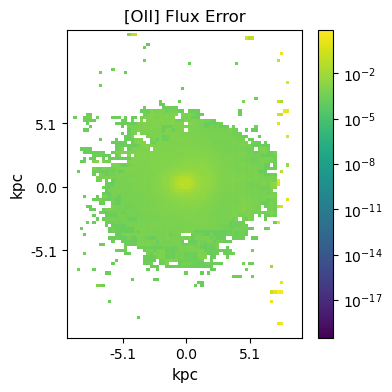

In [24]:
##### 1comp ##### 

%matplotlib inline
err_fc_1comp = data_flx_err_1comp[0][1][0][8]
o2_err_1comp = err_map(ion,err_fc_1comp, '[OII] Flux Error', kpc=True) #Error map to evaluate error threshold, no cuts
# savefig('o2_error_1comp.pdf')
#CHANGE to err_fc_1comp for 1 component fit

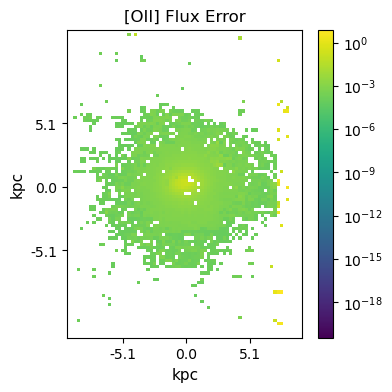

In [25]:
##### 2comp c1##### 

%matplotlib inline
err_fc1_2comp = data_flx_err_2comp[5][1][0][8]
o2_err_2comp = err_map(ion,err_fc1_2comp, '[OII] Flux Error', kpc=True) #Error map to evaluate error threshold, no cuts
# savefig('o2_error_1comp.pdf')
#CHANGE to err_fc_1comp for 1 component fit

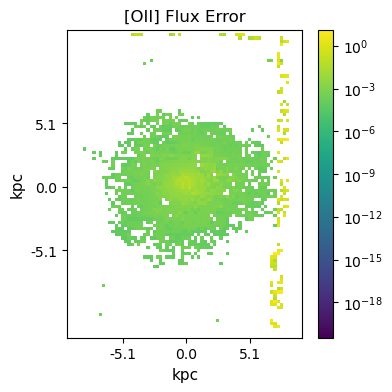

In [26]:
##### 3comp c1##### 

%matplotlib inline
err_fc1_3comp = data_flx_err_3comp[5][1][0][8]
o2_err_3comp = err_map(ion,err_fc1_3comp, '[OII] Flux Error', kpc=True) #Error map to evaluate error threshold, no cuts
# savefig('o2_error_1comp.pdf')
#CHANGE to err_fc_1comp for 1 component fit

0.0 0.029689331162638083


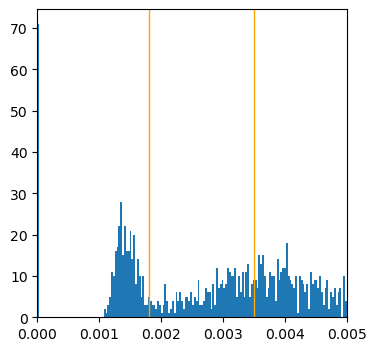

In [29]:
%matplotlib inline

o2_err_temp = o2_err_3comp

figure(figsize=(4,4))
ax = subplot(111)
plt.xlim(0,0.005)

index = np.where(o2_err_temp < 0.03)
newlist_2 = o2_err_temp[index]

ax.hist(newlist_2,bins=1000)
ax.axvline( x = 0.0035, c='orange', lw=1, ls='-')
ax.axvline( x = 0.0018, c='orange', lw=1, ls='-')
# ax.axvline( x = 0.0002, c='orange', lw=1, ls='-')


print(np.min(newlist_2), np.max(newlist_2))
# savefig('o2_errorhist_1comp.pdf')

# Functions to plot kinematics maps

In [74]:
def plot_kin(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable(idx, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -400, 400,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -1000, 300,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -300, 1000,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)

def plot_kin_c2(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable(idx, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -600, 600,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -600, 1000,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -2000, 600,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)

def plot_kin_c3(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable(idx, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -1100, 1100,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -600, 1000,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -2000, 600,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)
    
def sub_plot(var,vmin,vmax,color_map,spx_x=None, spx_y=None, width=None, height=None,spx=False, rec= False,title=None,scale=None,  lab_x=False, lab_y=False):
    imshow(var, origin='lower', cmap=color_map, vmin=vmin, vmax=vmax, interpolation='none')
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)

    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

    if spx == True:
        plt.plot(spx_x, spx_y, marker="x", markersize=5, markeredgecolor="magenta", markerfacecolor="magenta")
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect) 
    ax.title.set_text(title)  
    
    ax.set_xticks([16, 36, 56])
    ax.set_yticks([30, 50, 70]) 
    
    if scale == 'kpc':
        ax.set_xticklabels(np.round(np.array([-20, 0 , 20])*pixel_scale,1),size=9)
        ax.set_yticklabels(np.round(np.array([-20, 0 , 20])*pixel_scale,1),size=9)
        label = r'kpc'
    elif scale == 'arcsec':
        ax.set_xticklabels(np.round(np.array([-20, 0 , 20])*arcsec_pixel,1),size=9)
        ax.set_yticklabels(np.round(np.array([-20, 0 , 20])*arcsec_pixel,1),size=9)
        label = r'arcsec'
    else:
        label=r'spaxel'

    if lab_x == False: 
        ax.set_xlabel(label,fontsize=11)
    if lab_y == False:  
        ax.set_ylabel(label,fontsize=11)
 

    

# Function to get data of one spaxel

In [32]:
def get_values(idx,  f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp,  spx_x, spx_y):
    v50_line = get_variable(idx, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable(idx, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable(idx, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable(idx, f_temp, err_f_temp, v98_temp)
       
    o2 = f_temp[ion][1][spx_y][spx_x]
    o2_err = err_f_temp[ion][1][spx_y][spx_x]

    ## nat added
    # print('flux', round(f_temp[spx_y][spx_x],2))

    print('v50', round(v50_line[spx_y][spx_x],2), 'vsig', round(vsig_line[spx_y][spx_x],2), 'v02', round(v02_line[spx_y][spx_x],2), 'v98', round(v98_line[spx_y][spx_x],2))
    print('o2 flux', round(o2,4), 'o2_err', round(o2_err,4), 'SNR', round(o2/o2_err,2))
    

# Functions to Plot Fits

In [33]:
import matplotlib.ticker as ticker

class Spaxel:
    def __init__(self, infile):
        self.xdr = readsav(infile)
        self.xdr_arr = self.xdr['struct']
        self.wave = self.xdr_arr['wave'][0]
        self.spectot = self.xdr_arr['spec'][0]
        self.specstars = self.xdr_arr['cont_dat'][0]
        self.speclines = self.xdr_arr['emlin_dat'][0]
        self.modstars = self.xdr_arr['cont_fit'][0]
        self.modlines = self.xdr_arr['emlin_fit'][0]
        self.specerr = self.xdr_arr['spec_err'][0]
        self.modtot = self.modstars + self.modlines
        if self.xdr_arr['param'] !=0:
            self.ppoff = self.xdr_arr['param'][0][0]
            self.ncomp = self.xdr_arr['param'][0][1].astype(int)
            self.specres = self.xdr_arr['param'][0][2]
            self.rem_lis = []
        else:
            self.ncomp  = 0
        print(self.ncomp)
        
    def cmplin(self, line, comp):
        if comp == 0:
            return 0
        c = 299792.458
        indices = (self.xdr_arr['parinfo'][0]['line'] == line) & (self.xdr_arr['parinfo'][0]['comp'] == comp)
        if indices[0] != -1:
            gausspar = self.xdr_arr['param'][0][indices]
            gaussparRound = np.around(gausspar, decimals = 7)
            gaussparStr = list(map(str, gaussparRound))
            units = ['', ' Ang', ' km/s']
            gaussparFinal = []
            for i in range(len(gaussparStr)):
                gaussparFinal.append(gaussparStr[i] + units[i])
            #print(gaussparFinal)
            
            if len(gausspar) > 0 and not line in self.rem_lis:
                gausspar[2] = sqrt((gausspar[2]*gausspar[1]/c)**2. + self.specres**2.)
                if gausspar[2] == 0 or gausspar[0] == 0:
                    flux = zeros(len(self.wave)) * nan
                else:
                     flux = gaussian(self.wave,*gausspar)
            else:
                flux = zeros(len(self.wave)) * nan
        return flux
    
    def plot_lines(self, ax, lines, xmin, xmax):
        ax.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                ax.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        ax.plot(self.wave, self.modstars + self.modlines, 'C3')
        ax.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        self.limits(self.wave, xmin, xmax, 2.8)

    def plot_line_vel(self, ax, line, wave, z, vmin, vmax, lw=None):
        c = 299792.458
        wobs = wave * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        ax.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in line:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                ax.plot(vel, self.cmplin(l, i), style, lw=1.)
        ax.plot(vel, self.modlines, 'C3', lw=lw)
        self.limits(vel, vmin, vmax, 1.8)

        ax.axvline(0,color='k', ls='--', lw=0.5)
        ax.set_yticks(())
        ax.set_xlabel('(km s$^{-1}$)', fontsize=6, labelpad=-1)
        ax.set_ylabel('flux')

    def plot_lines_pdf(self, lines, xmin, xmax, str_x, str_y, pr=False):
        plt.plot(self.wave, self.modstars + self.speclines, 'k', ds='steps-mid', lw=1.)
        col = ['','0','1','2']
        for l in lines:
            for i in range(1,self.ncomp+1):
                style = 'C' + col[i] + '--'
                plt.plot(self.wave,self.modstars + self.cmplin(l, i), style)
        plt.plot(self.wave, self.modstars + self.modlines, 'C3')
        plt.plot(self.wave, self.specerr, 'C6:', ds='steps-mid', lw=1.)
        ymax = self.limits(self.wave, xmin, xmax, 1.3)
        
        if pr == True:
            plt.text(plot_limits[0]+15, ymax*0.9,  str_x + '_' + str_y, fontsize=9)
            
    def limits(self, var, _min, _max, factor):
        yi = self.speclines[(var > _min) & (var < _max)] + self.modstars[(var > _min) & (var < _max)]
        erri = self.specerr[(var > _min) & (var < _max)]
        ymax = max(factor * amax(yi), 3. * amax(erri))
        ymin =  -ymax*0.2
        plt.xlim(_min, _max)
        plt.ylim(ymin, ymax)
        return ymax
        
    def plot_line_vel_pdf(self, line, wave_o, z, vmin, vmax,       str_x, str_y, sn1=None, sn2=None, lw=None, sn = False):
        c = 299792.458
        wobs = wave_o * (1. + z)
        vel = c * (self.wave - wobs) / wobs
        plt.plot(vel, self.speclines, 'k', drawstyle='steps-mid', lw=1.)
        if self.ncomp!=0:
            col = ['','0','1','2']
            for l in line:
                for i in range(1,self.ncomp+1):
                    style = 'C' + col[i] + '--'
                    plt.plot(vel, self.cmplin(l, i), style, lw=1.)
            plt.plot(vel, self.modlines, 'C3', lw=lw)
        ymax = self.limits(vel, vmin, vmax, 1.2)
        plt.axvline(0,color='k', ls='--', lw=0.5)
        if sn == True and self.ncomp!=0:
            plt.text(100, ymax*0.9,  'SNR1='+str(round(sn1,1)), fontsize=7)
            plt.text(100, ymax*0.8,  'SNR2='+str(round(sn2,1)), fontsize=7)
        ##nat added
        plt.text(plot_limits[0]+15, ymax*0.9,  str_x + '_' + str_y, fontsize=9)
            
        
def gaussian(x, A, u, sig):
    return A * exp(-(x-u)**2. / 2. / sig**2.)

def plot_spaxel(ax, spax, lxticks=False, ltitle=False, rem=False):
    if ion_tag == 'o2': 
        spax.plot_lines(ax, ion_line, plot_limits[0], plot_limits[1])
        ax.axvline((z+1)*ion_wave_0, color='k', ls='--', lw=0.5)
        ax.axvline((z+1)*ion_wave_1, color='k', ls='--', lw=0.5)
        if ltitle:
            ax.title.set_text('[OII]3726,9')
    elif ion_tag == 'o3':
        spax.plot_lines(ax, ion_line, plot_limits[0], plot_limits[1])
        ax.axvline((z+1)*ion_wave_0, color='k', ls='--', lw=0.5)
        ax.axvline((z+1)*ion_wave_1, color='k', ls='--', lw=0.5)
        if ltitle:
            ax.title.set_text('[OIII]5007')

def plot_spaxel_pdf(spax, str_x, str_y, lxticks=False, ltitle=False, rem=False, pr= False):
        spax.plot_lines_pdf(ion_line, plot_limits[0], plot_limits[1], str_x, str_y, pr)
        plt.axvline((z+1)*ion_wave_0, color='k', ls='--', lw=0.5)
        plt.axvline((z+1)*ion_wave_1, color='k', ls='--', lw=0.5)

# Spaxel to investigate

In [34]:
spx_x = 39
spx_y = 45

# 1 Component Fit

In [36]:
# using c1 data 
fc_1comp = data_flx_1comp[fc1_1comp_idx][1][0][8]
err_fc_1comp = data_flx_err_1comp[fc1_1comp_idx][1][0][8]

vsig_1comp = vel_arr_1comp[vsig_c1_1comp_idx][1][0][8]
v50_1comp = vel_arr_1comp[v50_c1_1comp_idx][1][0][8]
v98_1comp = vel_arr_1comp[v98_c1_1comp_idx][1][0][8]
v02_1comp = vel_arr_1comp[v02_c1_1comp_idx][1][0][8]

snr_1comp = get_sn(ion,fc_1comp,err_fc_1comp)

In [37]:
spaxel_test = get_values(ion,fc_1comp, err_fc_1comp, v50_1comp, vsig_1comp, v02_1comp, v98_1comp, spx_x, spx_y)

v50 -521.01 vsig 434.34 v02 347.67 v98 -1389.68
o2 flux 0.6135 o2_err 0.0205 SNR 29.99


SNR = 29.99 v50 = -521.01


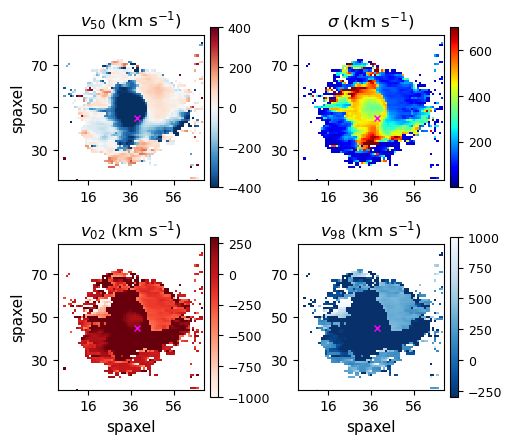

In [38]:
%matplotlib inline

custom_xlim = (2, 70)
custom_ylim = (16, 84)

plot_kin(ion, fc_1comp, err_fc_1comp, v50_1comp, vsig_1comp, v02_1comp, v98_1comp, spx_x, spx_y, spx=True)
print('SNR =', round(fc_1comp[ion][1][spx_y][spx_x]/err_fc_1comp[ion][1][spx_y][spx_x],2), 'v50 =',round(v50_1comp[ion][1][spx_y][spx_x],2)) 
# savefig(ion_tag + '_' +'1componentFit_kinematics.pdf')


# First Component 2 components Fit

In [39]:
fc1_2comp = data_flx_2comp[fc1_2comp_idx][1][0][8]
err_fc1_2comp = data_flx_err_2comp[fc1_2comp_idx][1][0][8]

vsig_c1_2comp = vel_arr_2comp[vsig_c1_2comp_idx][1][0][8]
v50_c1_2comp = vel_arr_2comp[v50_c1_2comp_idx][1][0][8]
v98_c1_2comp = vel_arr_2comp[v98_c1_2comp_idx][1][0][8]
v02_c1_2comp = vel_arr_2comp[v02_c1_2comp_idx][1][0][8]


snr_c1_2comp = get_sn(ion,fc1_2comp,err_fc1_2comp)

# v_50 histogram

(-200.0, 200.0)

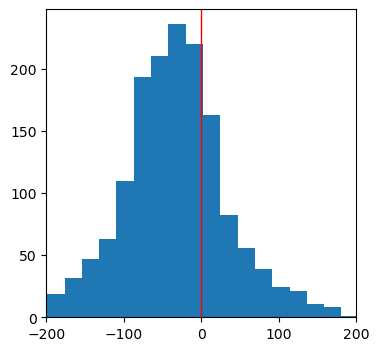

In [41]:
%matplotlib inline
figure(figsize=(4,4))
ax = subplot(111)

v_50_2comp_hist = get_variable(ion, fc1_2comp, err_fc1_2comp, v50_c1_2comp)
test_list = v_50_2comp_hist.flatten()
test_list = [x for x in test_list if str(x) != 'nan']

ax.hist(test_list,bins=100)
ax.axvline( x = 0, c='red', lw=1, ls='-')


ax.set_xlim(-200,200)
# savefig(ion_tag + '_' +'c1_v50_hist.pdf')

In [42]:
spaxel_test = get_values(ion,fc1_2comp, err_fc1_2comp, v50_c1_2comp, vsig_c1_2comp, v02_c1_2comp, v98_c1_2comp, spx_x, spx_y)

v50 -75.68 vsig 120.01 v02 164.35 v98 -315.7
o2 flux 0.7298 o2_err 0.0351 SNR 20.8


SNR = 20.8 v50 = -75.68


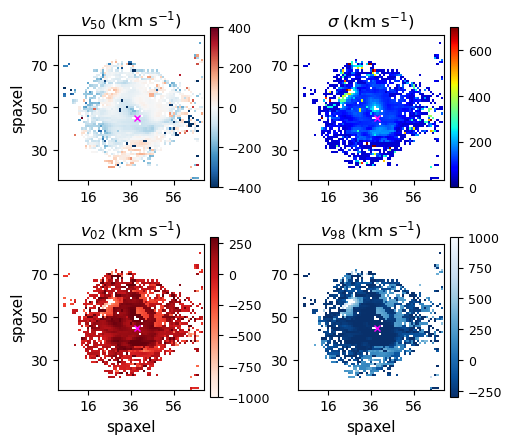

In [43]:
%matplotlib inline
plot_kin(ion, fc1_2comp, err_fc1_2comp, v50_c1_2comp, vsig_c1_2comp, v02_c1_2comp, v98_c1_2comp, spx_x, spx_y, spx=True)
print('SNR =', round(fc1_2comp[ion][1][spx_y][spx_x]/err_fc1_2comp[ion][1][spx_y][spx_x],2), 'v50 =',round(v50_c1_2comp[ion][1][spx_y][spx_x],2)) 
# savefig(ion_tag + '_' +'kinematics_firstcomp.pdf')


# Second Component 2 components Fit

In [44]:
fc2_2comp = data_flx_2comp[fc2_2comp_idx][1][0][8]
err_fc2_2comp = data_flx_err_2comp[fc2_2comp_idx][1][0][8]

vsig_c2_2comp = vel_arr_2comp[vsig_c2_2comp_idx][1][0][8]
v50_c2_2comp = vel_arr_2comp[v50_c2_2comp_idx][1][0][8]
v98_c2_2comp = vel_arr_2comp[v98_c2_2comp_idx][1][0][8]
v02_c2_2comp = vel_arr_2comp[v02_c2_2comp_idx][1][0][8]

snr_c2_2comp = get_sn(ion,fc2_2comp,err_fc2_2comp)

In [45]:
spaxel_test = get_values(ion,fc2_2comp, err_fc2_2comp, v50_c2_2comp, vsig_c2_2comp, v02_c2_2comp, v98_c2_2comp, spx_x, spx_y)

v50 -613.04 vsig 399.32 v02 185.6 v98 -1411.68
o2 flux 0.2559 o2_err 0.0168 SNR 15.25


<IPython.core.display.Javascript object>


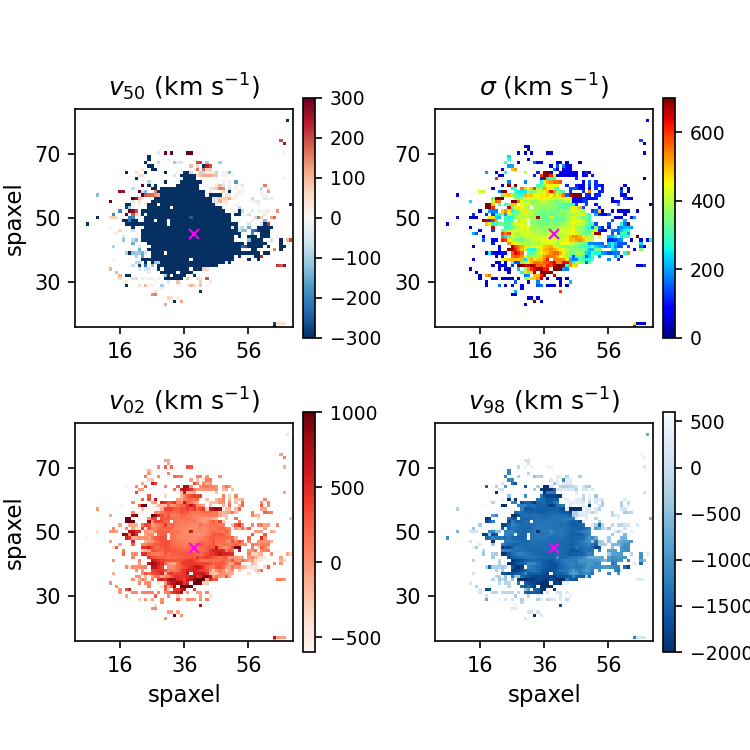

SNR = 15.25 v50 = -613.04


In [46]:
%matplotlib notebook
plot_kin_c2(ion, fc2_2comp, err_fc2_2comp, v50_c2_2comp, vsig_c2_2comp, v02_c2_2comp, v98_c2_2comp, spx_x, spx_y, spx=True)
print('SNR =', round(fc2_2comp[ion][1][spx_y][spx_x]/err_fc2_2comp[ion][1][spx_y][spx_x],2), 'v50 =',round(v50_c2_2comp[ion][1][spx_y][spx_x],2)) 
# savefig(ion_tag + '_' +'kinematics_secondcomp.pdf')

<IPython.core.display.Javascript object>


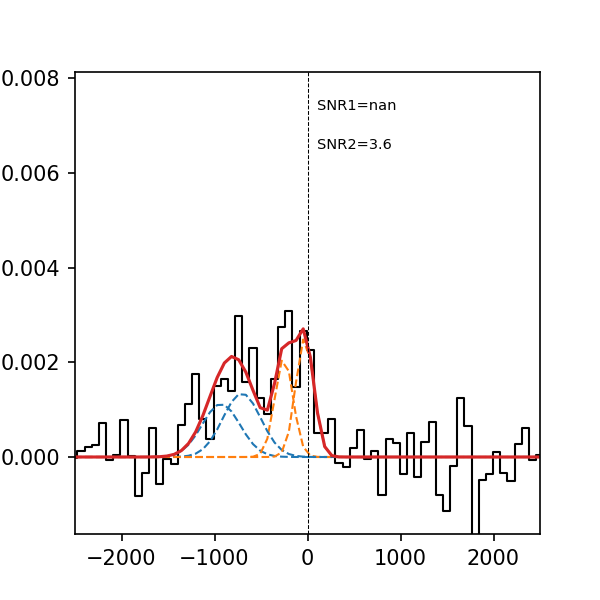

2


/tmp/ipykernel_11459/537403446.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.xdr_arr['param'] !=0:


In [103]:
spx_x = 58
spx_y = 41

%matplotlib notebook
figure(figsize=(4,4))
ax = subplot(111)

ne = Spaxel(path_2comp_fit + 'F05189_00' + str(spx_x+1) +'_00'+ str(spx_y+1) + '.xdr')
ne.plot_line_vel_pdf(ion_line, ion_wave_1, z, vel_lim[0], vel_lim[1], snr_c1[spx_y][spx_x], snr_c2[spx_y][spx_x], sn=True)


# c1 3comp fit

In [47]:
fc1_3comp = data_flx_3comp[fc1_3comp_idx][1][0][8]
err_fc1_3comp = data_flx_err_3comp[fc1_3comp_idx][1][0][8]

vsig_c1_3comp = vel_arr_3comp[vsig_c1_3comp_idx][1][0][8]
v50_c1_3comp = vel_arr_3comp[v50_c1_3comp_idx][1][0][8]
v98_c1_3comp = vel_arr_3comp[v98_c1_3comp_idx][1][0][8]
v02_c1_3comp = vel_arr_3comp[v02_c1_3comp_idx][1][0][8]


snr_c1_3comp = get_sn(ion,fc1_3comp,err_fc1_3comp)

## v_50 histogram

(-200.0, 200.0)

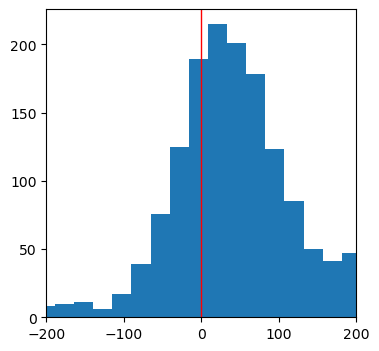

In [48]:
%matplotlib inline
figure(figsize=(4,4))
ax = subplot(111)

v_50_3comp_hist = get_variable(ion, fc1_3comp, err_fc1_3comp, v50_c1_3comp)
test_list = v_50_3comp_hist.flatten()
test_list = [x for x in test_list if str(x) != 'nan']

ax.hist(test_list,bins=100)
ax.axvline( x = 0, c='red', lw=1, ls='-')


ax.set_xlim(-200,200)
# savefig(ion_tag + '_' +'c1_v50_hist.pdf')

In [49]:
spaxel_test = get_values(ion,fc1_3comp, err_fc1_3comp, v50_c1_3comp, vsig_c1_3comp, v02_c1_3comp, v98_c1_3comp, spx_x, spx_y)

v50 0.19 vsig 158.1 v02 -316.01 v98 316.4
o2 flux 0.5873 o2_err 0.1202 SNR 4.89


SNR = 4.89 v50 = 0.19


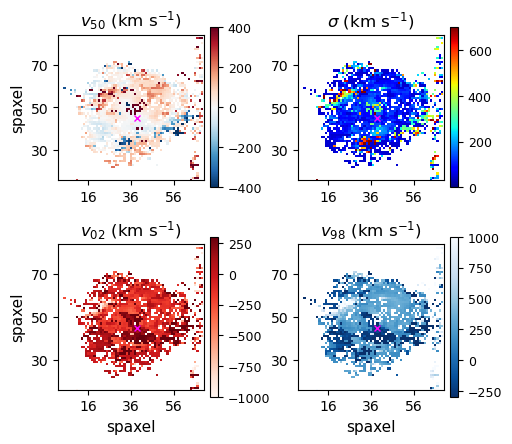

In [51]:
%matplotlib inline
plot_kin(ion, fc1_3comp, err_fc1_3comp, v50_c1_3comp, vsig_c1_3comp, v02_c1_3comp, v98_c1_3comp, spx_x, spx_y, spx=True)
print('SNR =', round(fc1_3comp[ion][1][spx_y][spx_x]/err_fc1_3comp[ion][1][spx_y][spx_x],2), 'v50 =',round(v50_c1_3comp[ion][1][spx_y][spx_x],2)) 
savefig(ion_tag + '_' +'kinematics_c1_3comp.pdf')


# c2 3comp fit

In [52]:
fc2_3comp = data_flx_3comp[fc2_3comp_idx][1][0][8]
err_fc2_3comp = data_flx_err_3comp[fc2_3comp_idx][1][0][8]

vsig_c2_3comp = vel_arr_3comp[vsig_c2_3comp_idx][1][0][8]
v50_c2_3comp = vel_arr_3comp[v50_c2_3comp_idx][1][0][8]
v98_c2_3comp = vel_arr_3comp[v98_c2_3comp_idx][1][0][8]
v02_c2_3comp = vel_arr_3comp[v02_c2_3comp_idx][1][0][8]


snr_c2_3comp = get_sn(ion,fc2_3comp,err_fc2_3comp)

In [53]:
spaxel_test = get_values(ion,fc2_3comp, err_fc2_3comp, v50_c2_3comp, vsig_c2_3comp, v02_c2_3comp, v98_c2_3comp, spx_x, spx_y)

v50 nan vsig nan v02 nan v98 nan
o2 flux 0.1743 o2_err 0.076 SNR 2.29


<IPython.core.display.Javascript object>


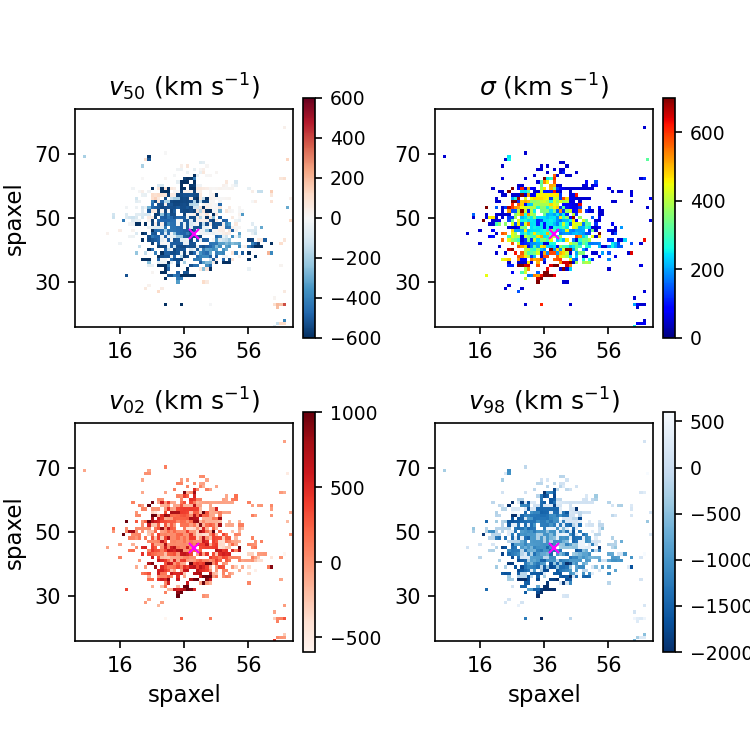

SNR = 2.29 v50 = -26.43


In [66]:
%matplotlib notebook
plot_kin_c2(ion, fc2_3comp, err_fc2_3comp, v50_c2_3comp, vsig_c2_3comp, v02_c2_3comp, v98_c2_3comp, spx_x, spx_y, spx=True)
print('SNR =', round(fc2_3comp[ion][1][spx_y][spx_x]/err_fc2_3comp[ion][1][spx_y][spx_x],2), 'v50 =',round(v50_c2_3comp[ion][1][spx_y][spx_x],2)) 
savefig(ion_tag + '_' +'kinematics_c2_3comp.pdf')


# c3 3comp fit

In [56]:
fc3_3comp = data_flx_3comp[fc3_3comp_idx][1][0][8]
err_fc3_3comp = data_flx_err_3comp[fc3_3comp_idx][1][0][8]

vsig_c3_3comp = vel_arr_3comp[vsig_c3_3comp_idx][1][0][8]
v50_c3_3comp = vel_arr_3comp[v50_c3_3comp_idx][1][0][8]
v98_c3_3comp = vel_arr_3comp[v98_c3_3comp_idx][1][0][8]
v02_c3_3comp = vel_arr_3comp[v02_c3_3comp_idx][1][0][8]


snr_c3_3comp = get_sn(ion,fc3_3comp,err_fc3_3comp)

In [57]:
spaxel_test = get_values(ion,fc3_3comp, err_fc3_3comp, v50_c3_3comp, vsig_c3_3comp, v02_c3_3comp, v98_c3_3comp, spx_x, spx_y)

v50 -551.46 vsig 393.62 v02 235.78 v98 -1338.69
o2 flux 0.2202 o2_err 0.0166 SNR 13.28


<IPython.core.display.Javascript object>


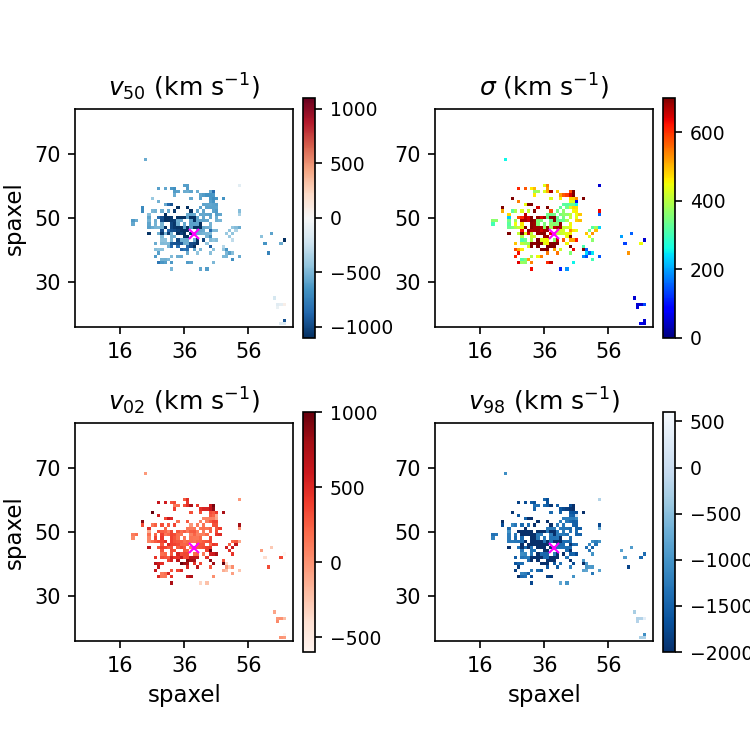

SNR = 13.28 v50 = -551.46


In [75]:
%matplotlib notebook
plot_kin_c3(ion, fc3_3comp, err_fc3_3comp, v50_c3_3comp, vsig_c3_3comp, v02_c3_3comp, v98_c3_3comp, spx_x, spx_y, spx=True)
print('SNR =', round(fc3_3comp[ion][1][spx_y][spx_x]/err_fc3_3comp[ion][1][spx_y][spx_x],2), 'v50 =',round(v50_c3_3comp[ion][1][spx_y][spx_x],2)) 
savefig(ion_tag + '_' +'kinematics_c3_3comp.pdf')


# Plot Maps and File region with fits

In [78]:
x_y_start = [32,43]
x_y_end = [40,52]

size_x = x_y_end[0] - x_y_start[0] + 1
size_y = x_y_end[1] - x_y_start[1] + 1

<IPython.core.display.Javascript object>


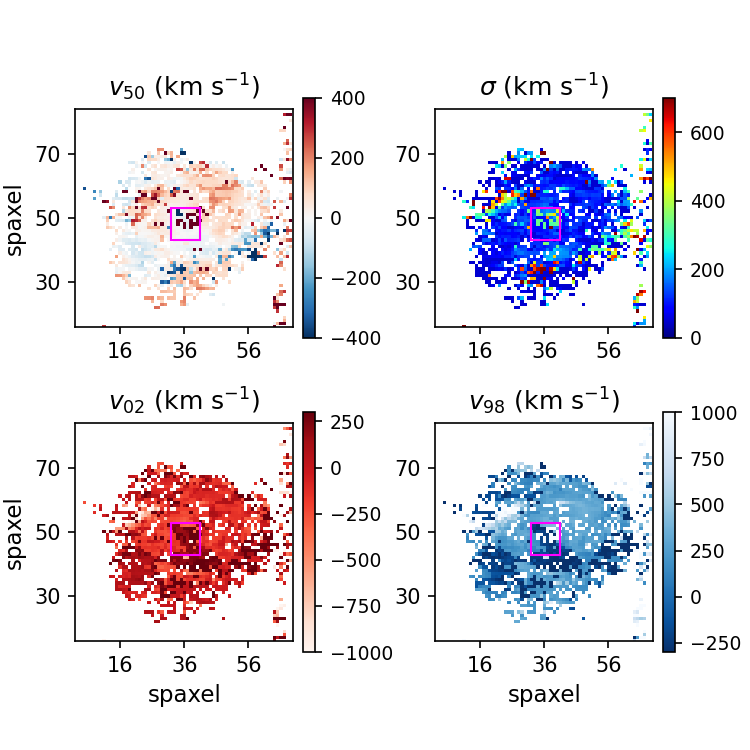

In [79]:
%matplotlib notebook
plot_kin(ion, fc1_3comp, err_fc1_3comp, v50_c1_3comp, vsig_c1_3comp, v02_c1_3comp, v98_c1_3comp, x_y_start[0], x_y_start[1], size_x, size_y, rec = True)
# savefig(ion_tag + '_' + 'kinematics_first_comp_'+str(x_y_start[0])+str(x_y_start[1])+'_'+str(x_y_end[0])+str(x_y_end[1])+'.pdf')

<IPython.core.display.Javascript object>


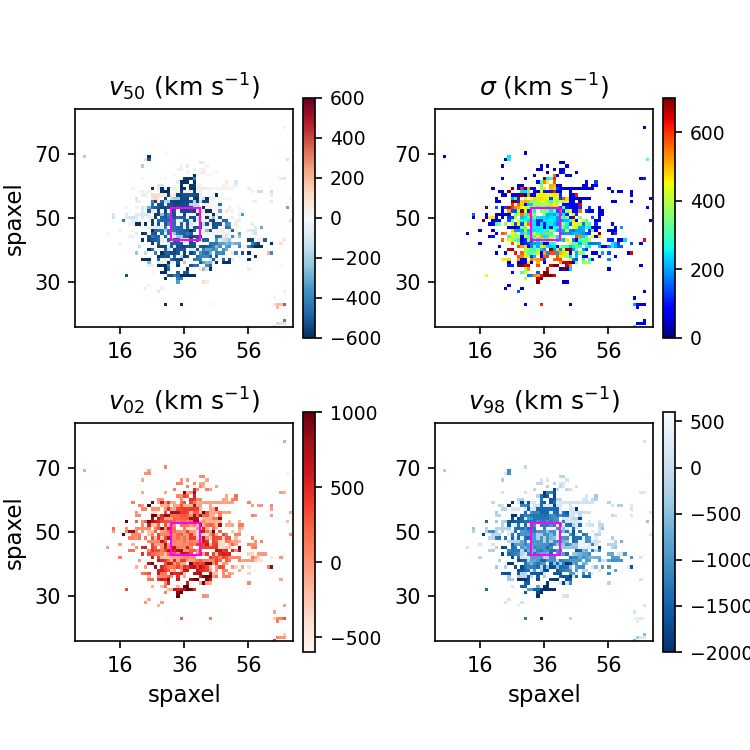

In [80]:
%matplotlib notebook
plot_kin_c2(ion, fc2_3comp, err_fc2_3comp, v50_c2_3comp, vsig_c2_3comp, v02_c2_3comp, v98_c2_3comp, x_y_start[0], x_y_start[1], size_x, size_y, rec = True)
# savefig(ion_tag + '_' + 'kinematics_second_comp_'+str(x_y_start[0])+str(x_y_start[1])+'_'+str(x_y_end[0])+str(x_y_end[1])+'.pdf')

<IPython.core.display.Javascript object>


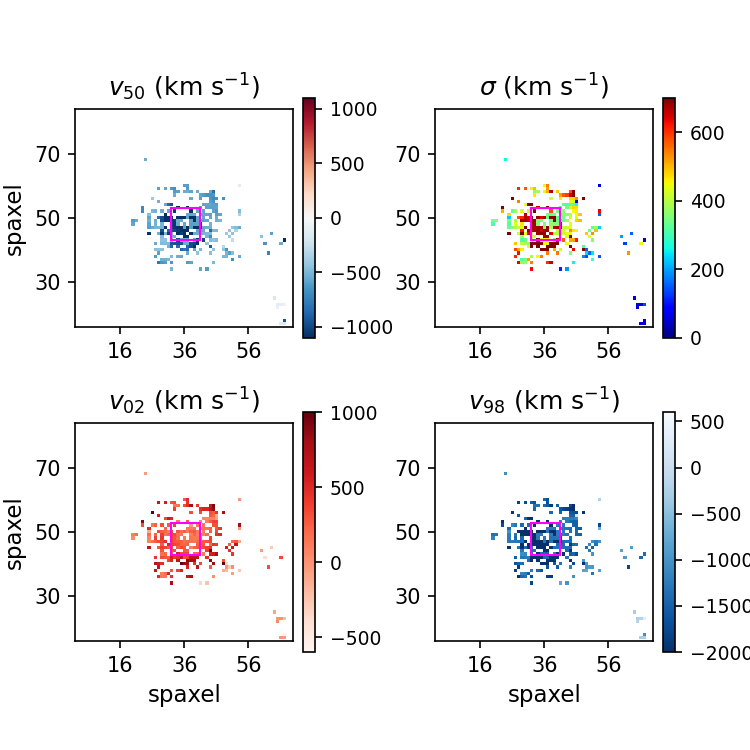

In [81]:
%matplotlib notebook
plot_kin_c3(ion, fc3_3comp, err_fc3_3comp, v50_c3_3comp, vsig_c3_3comp, v02_c3_3comp, v98_c3_3comp, x_y_start[0], x_y_start[1], size_x, size_y, rec = True)
# savefig(ion_tag + '_' + 'kinematics_second_comp_'+str(x_y_start[0])+str(x_y_start[1])+'_'+str(x_y_end[0])+str(x_y_end[1])+'.pdf')

<IPython.core.display.Javascript object>


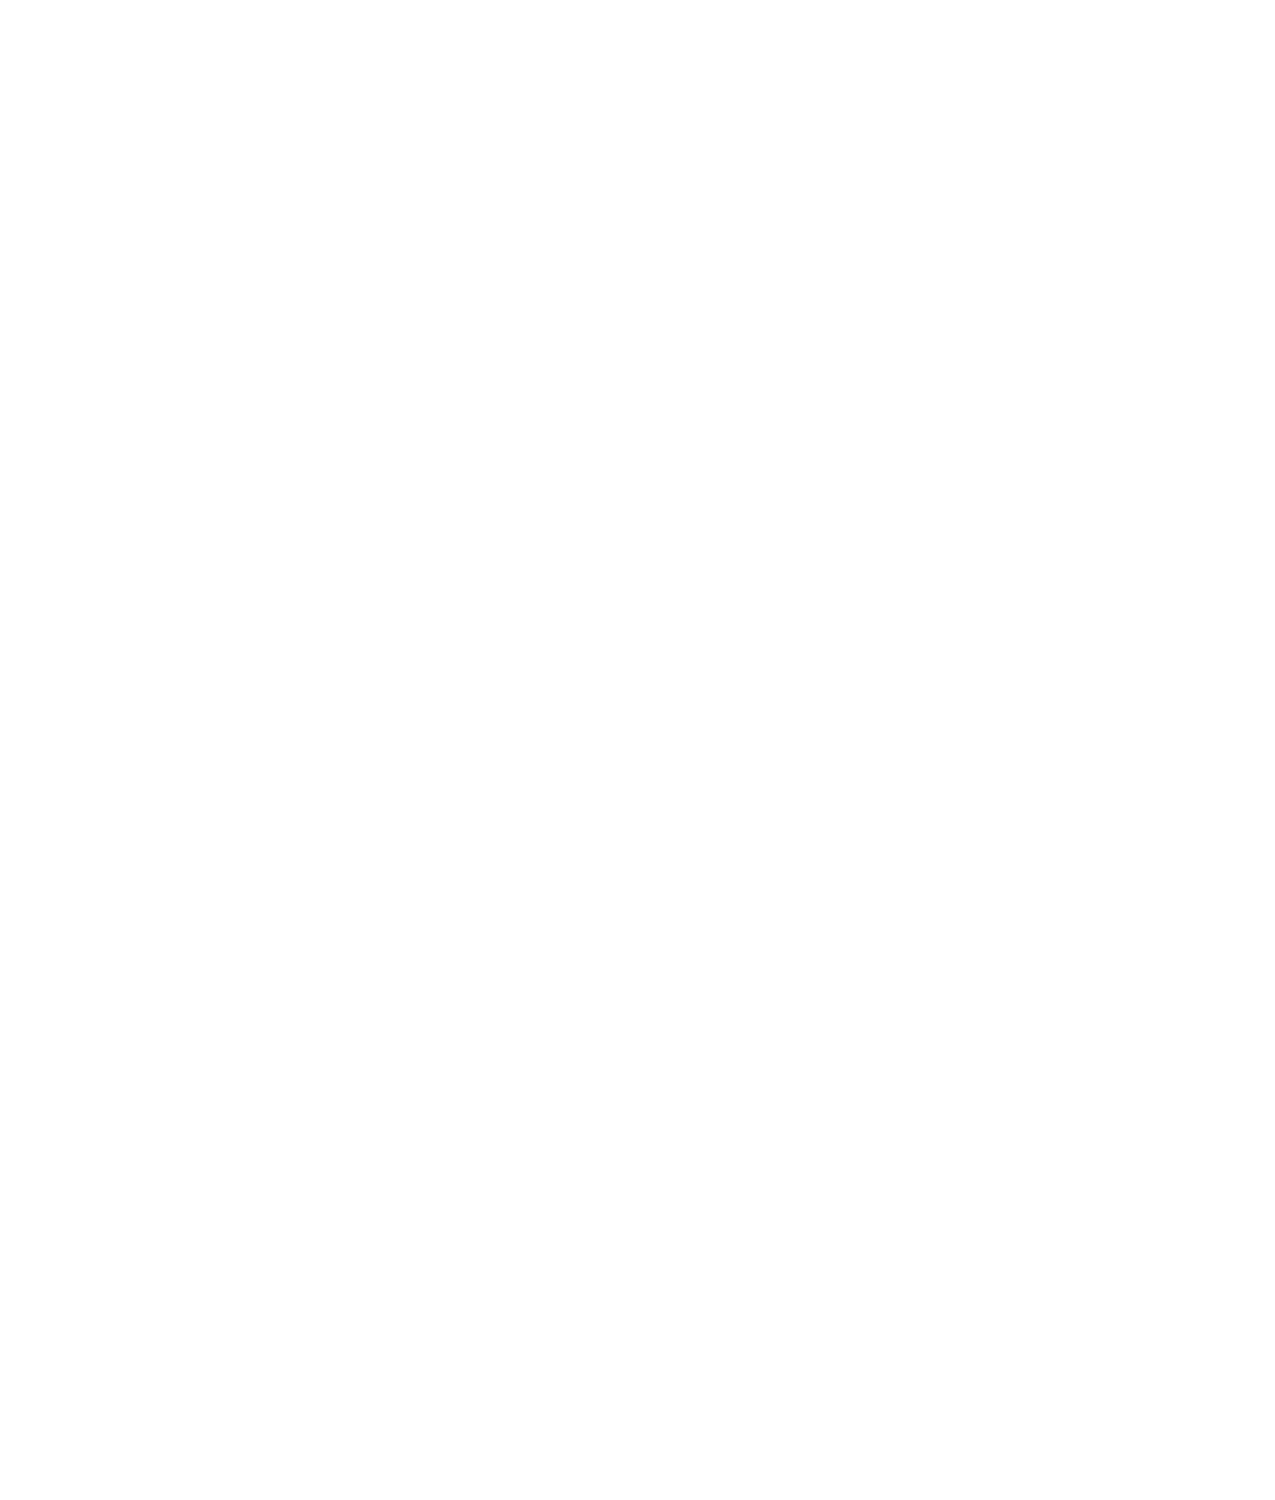

/tmp/ipykernel_21749/1094444628.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if self.xdr_arr['param'] !=0:


2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


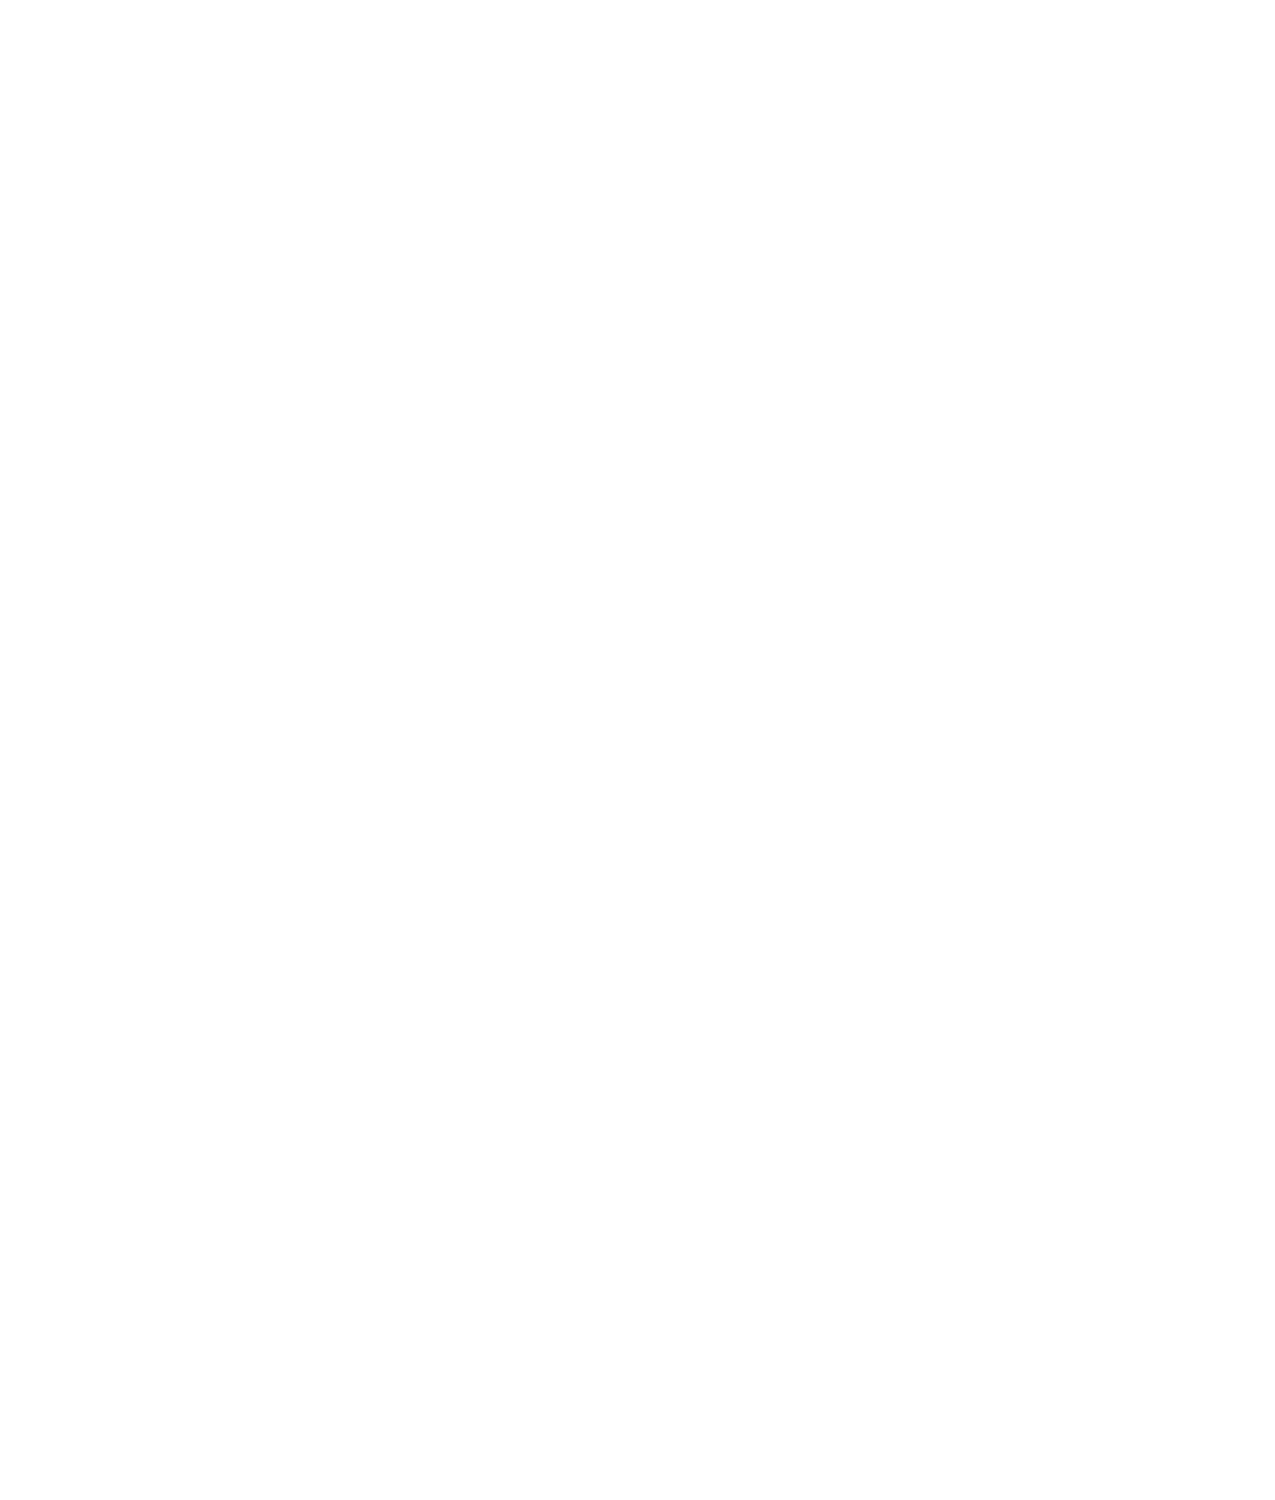

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


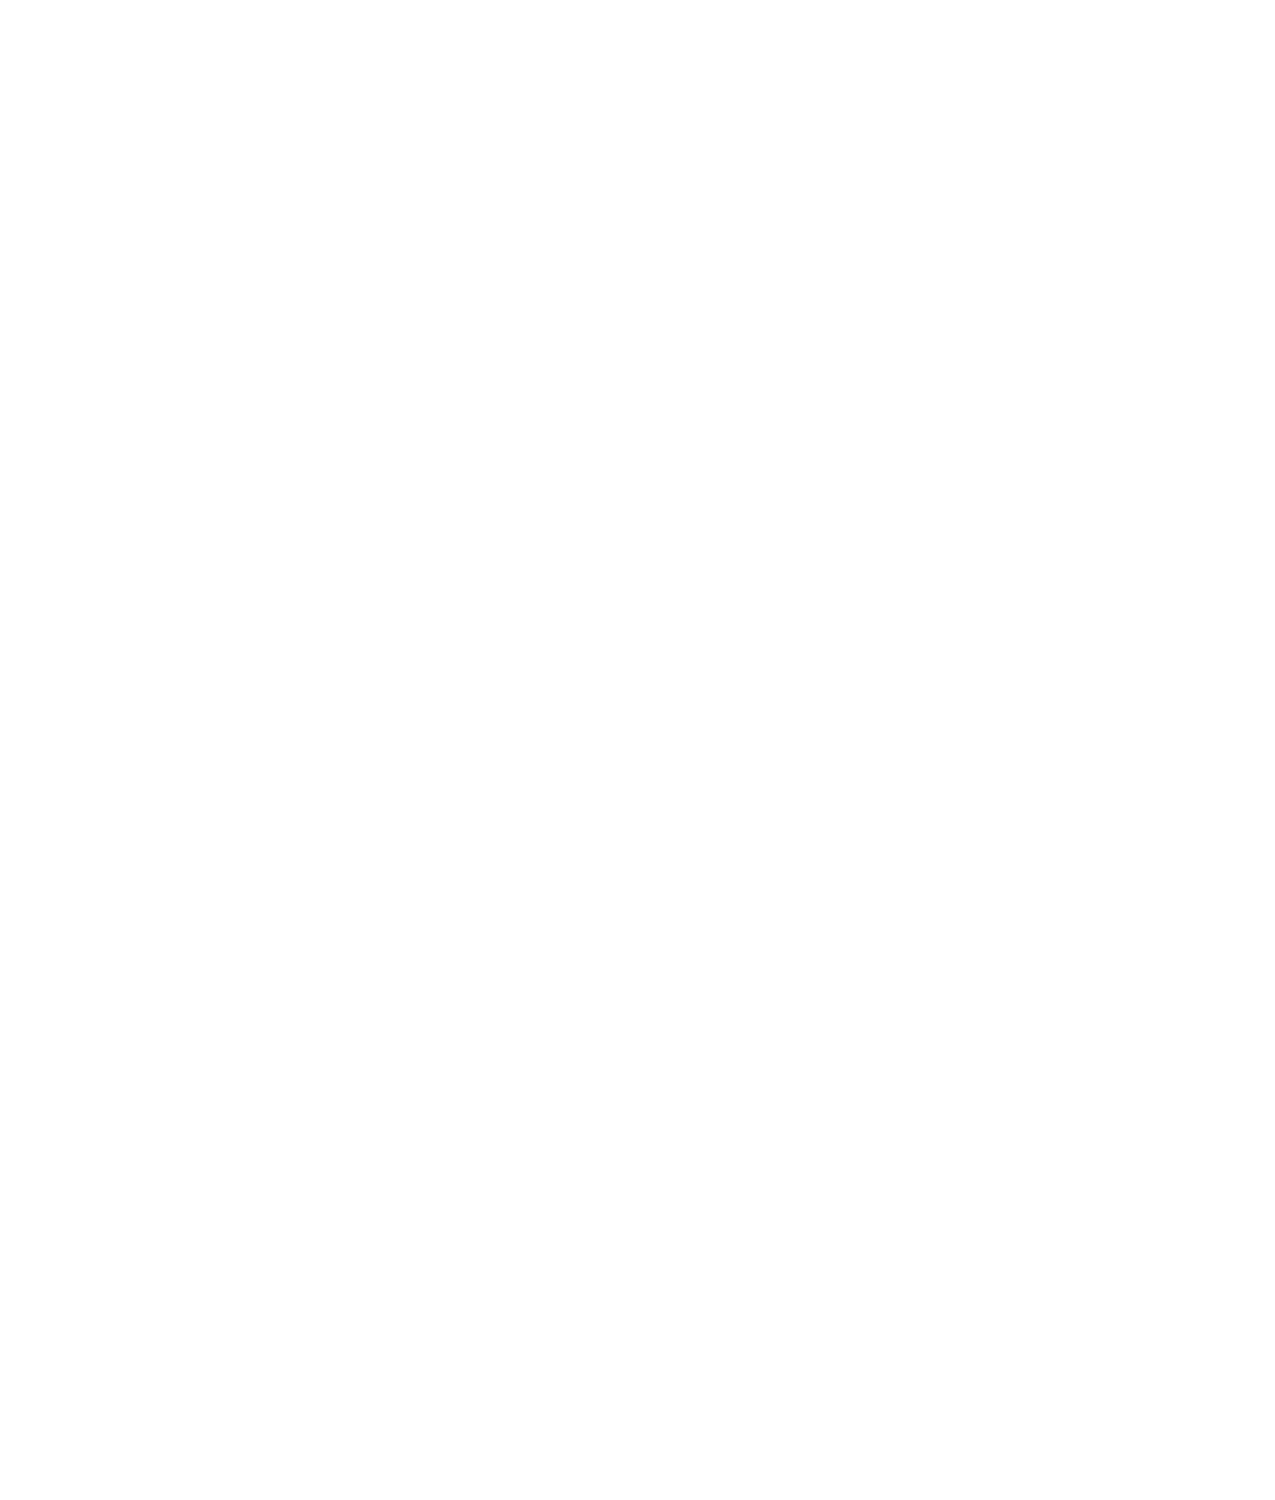

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


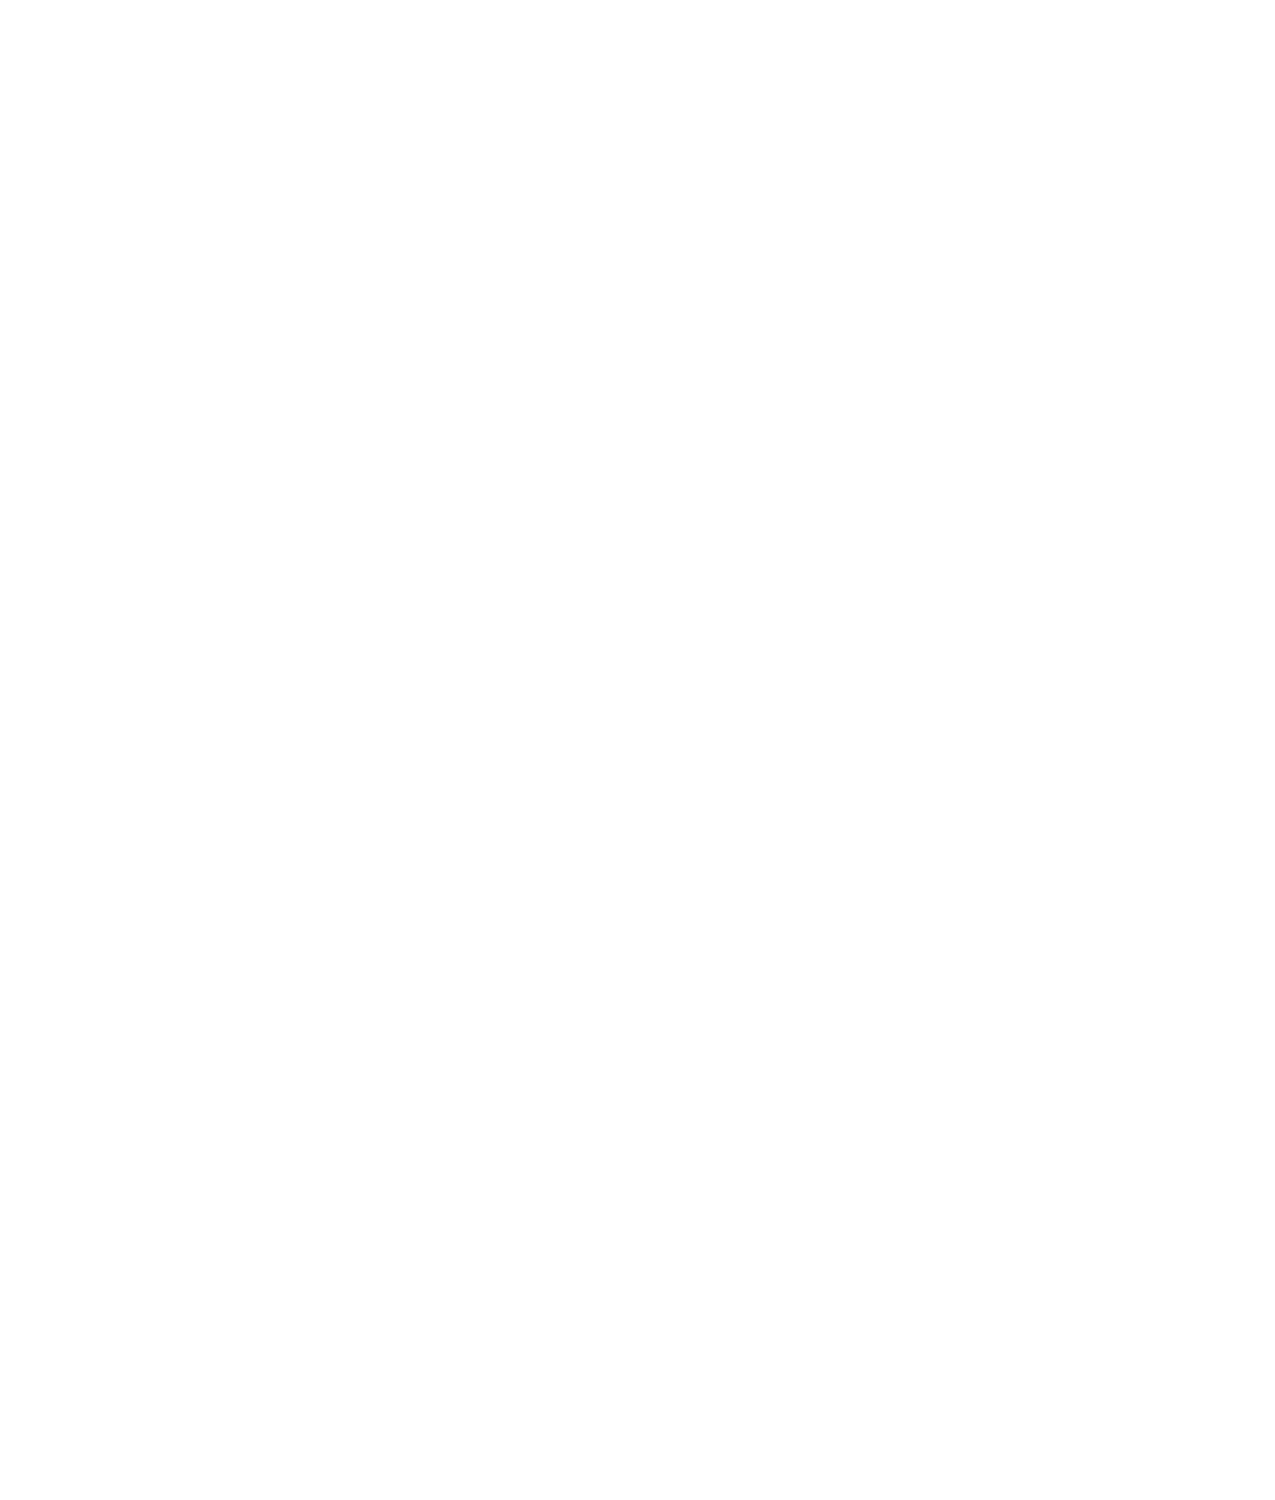

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


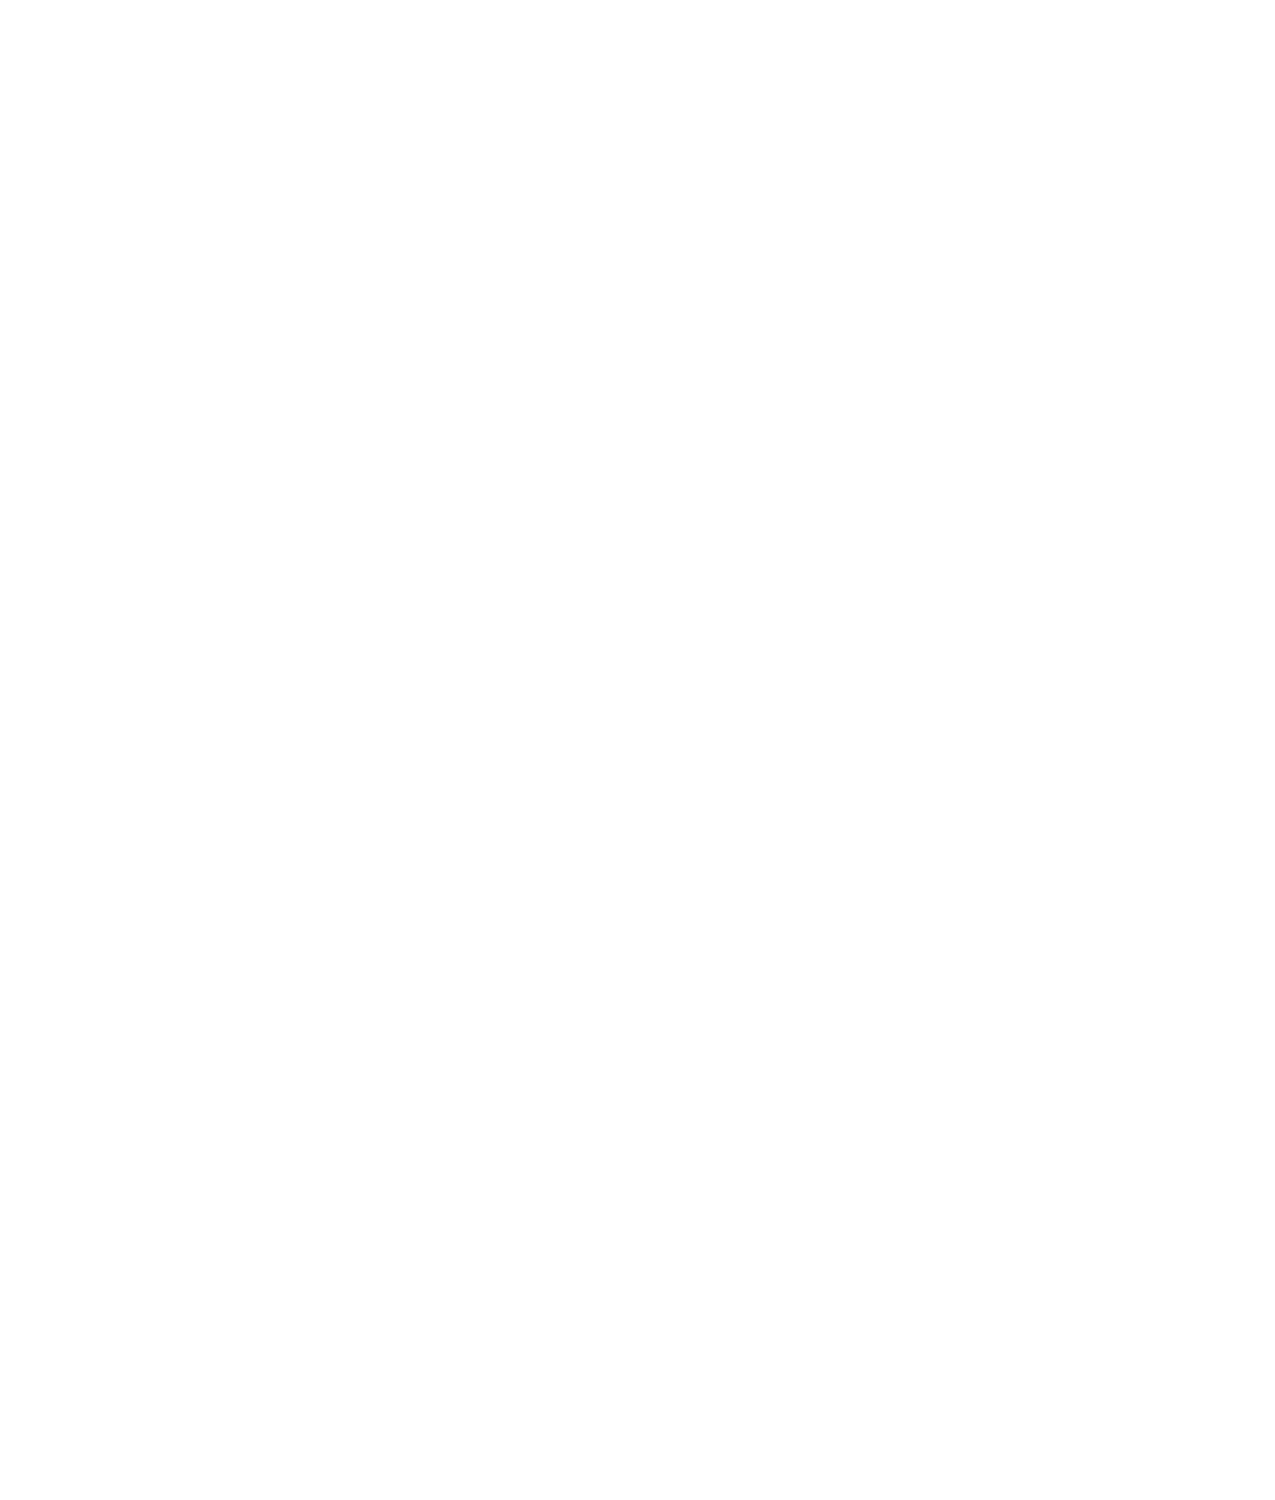

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


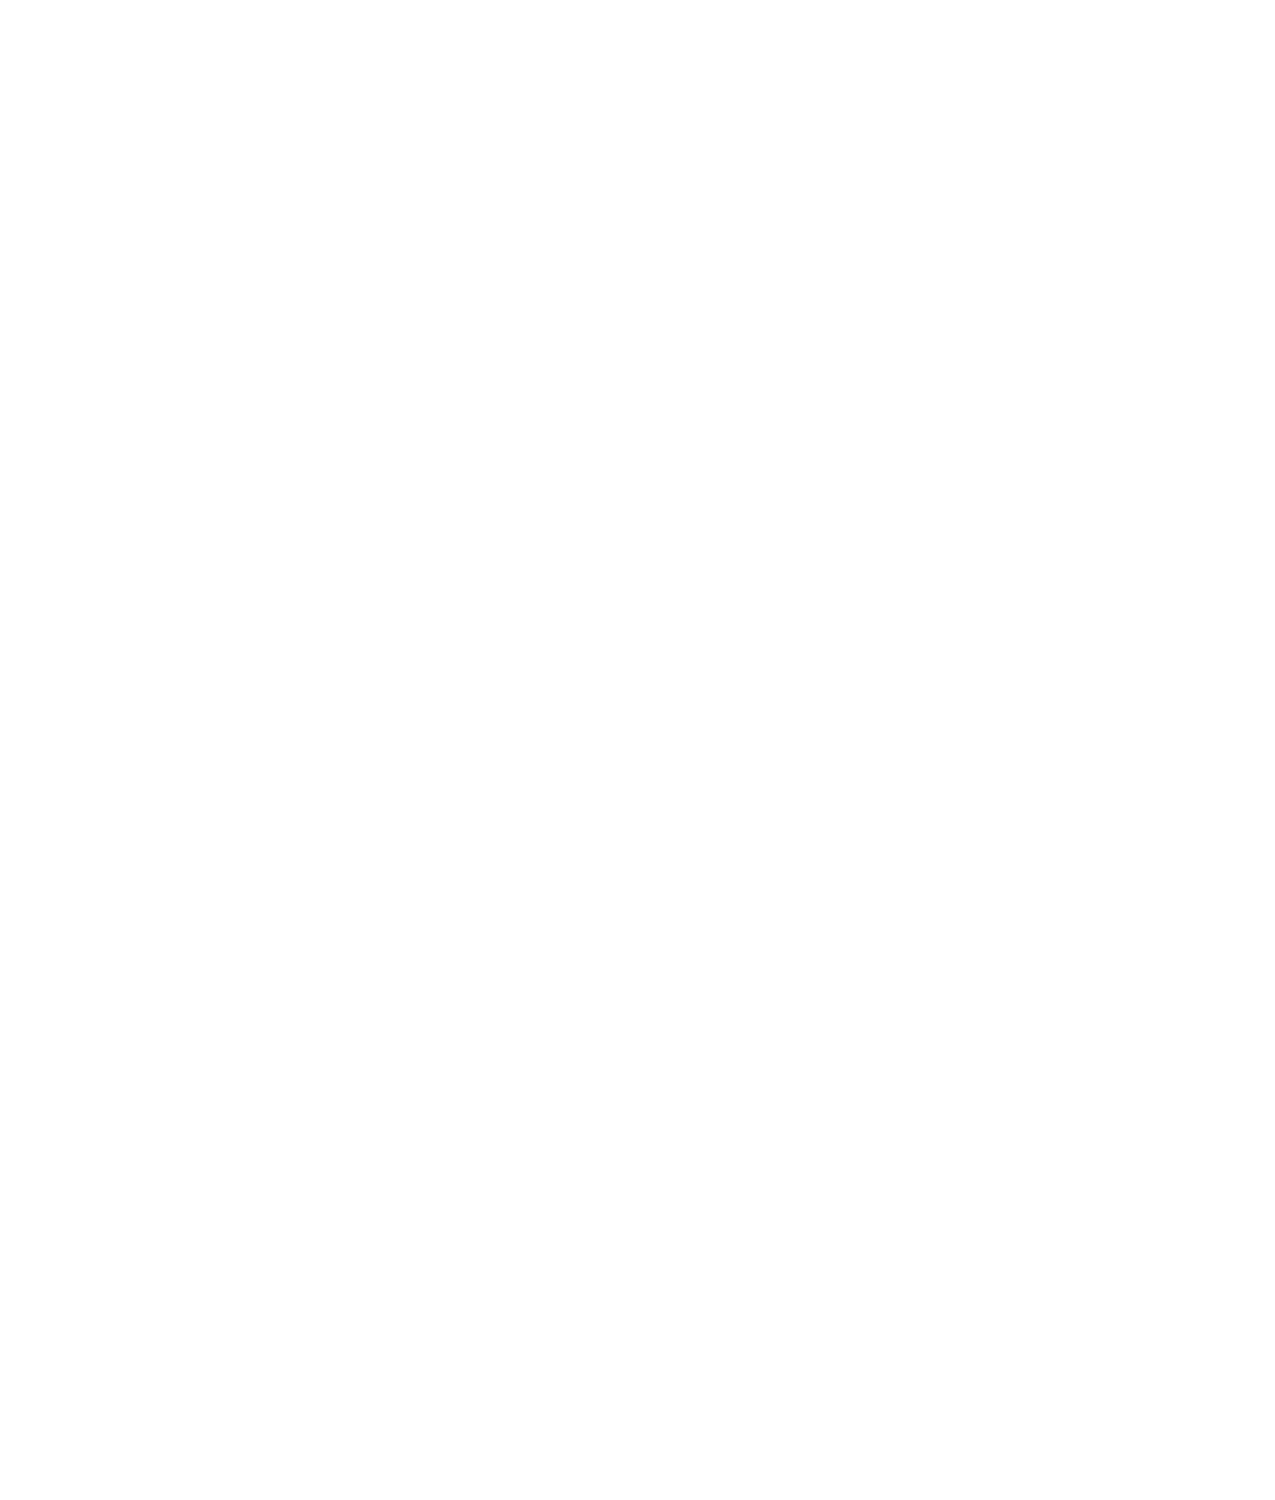

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


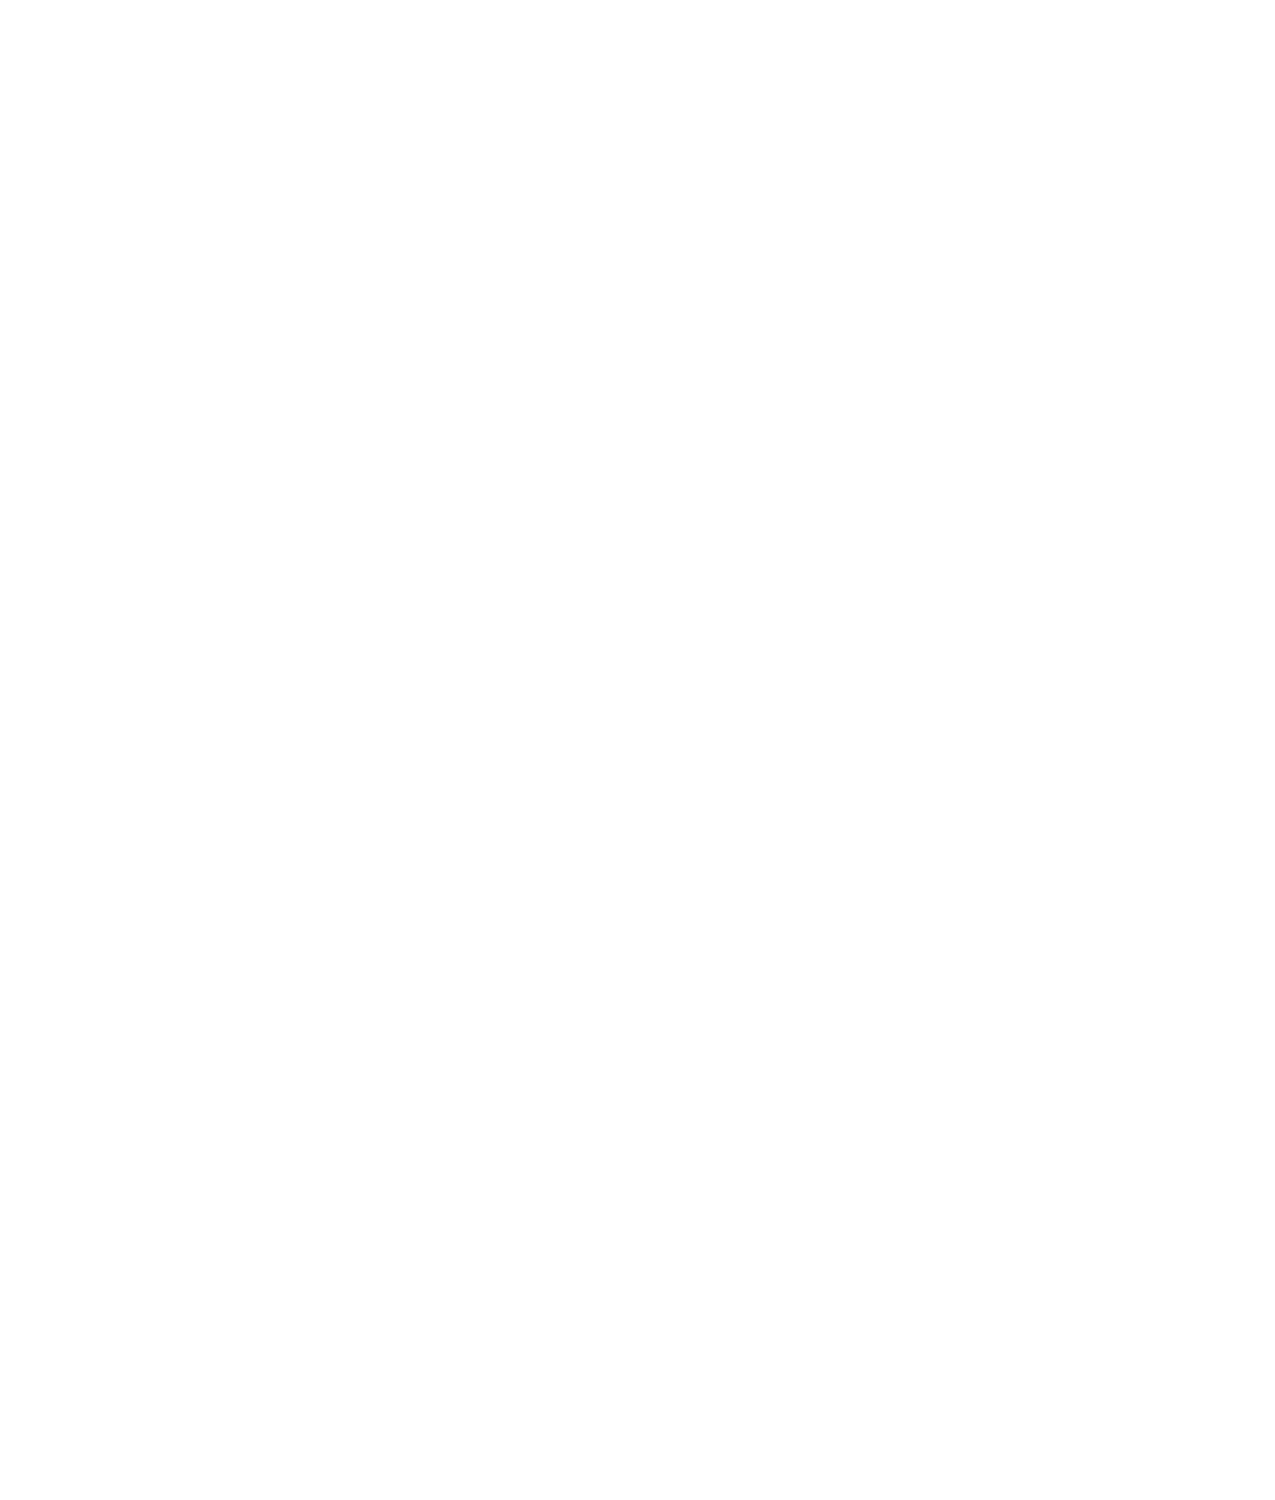

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


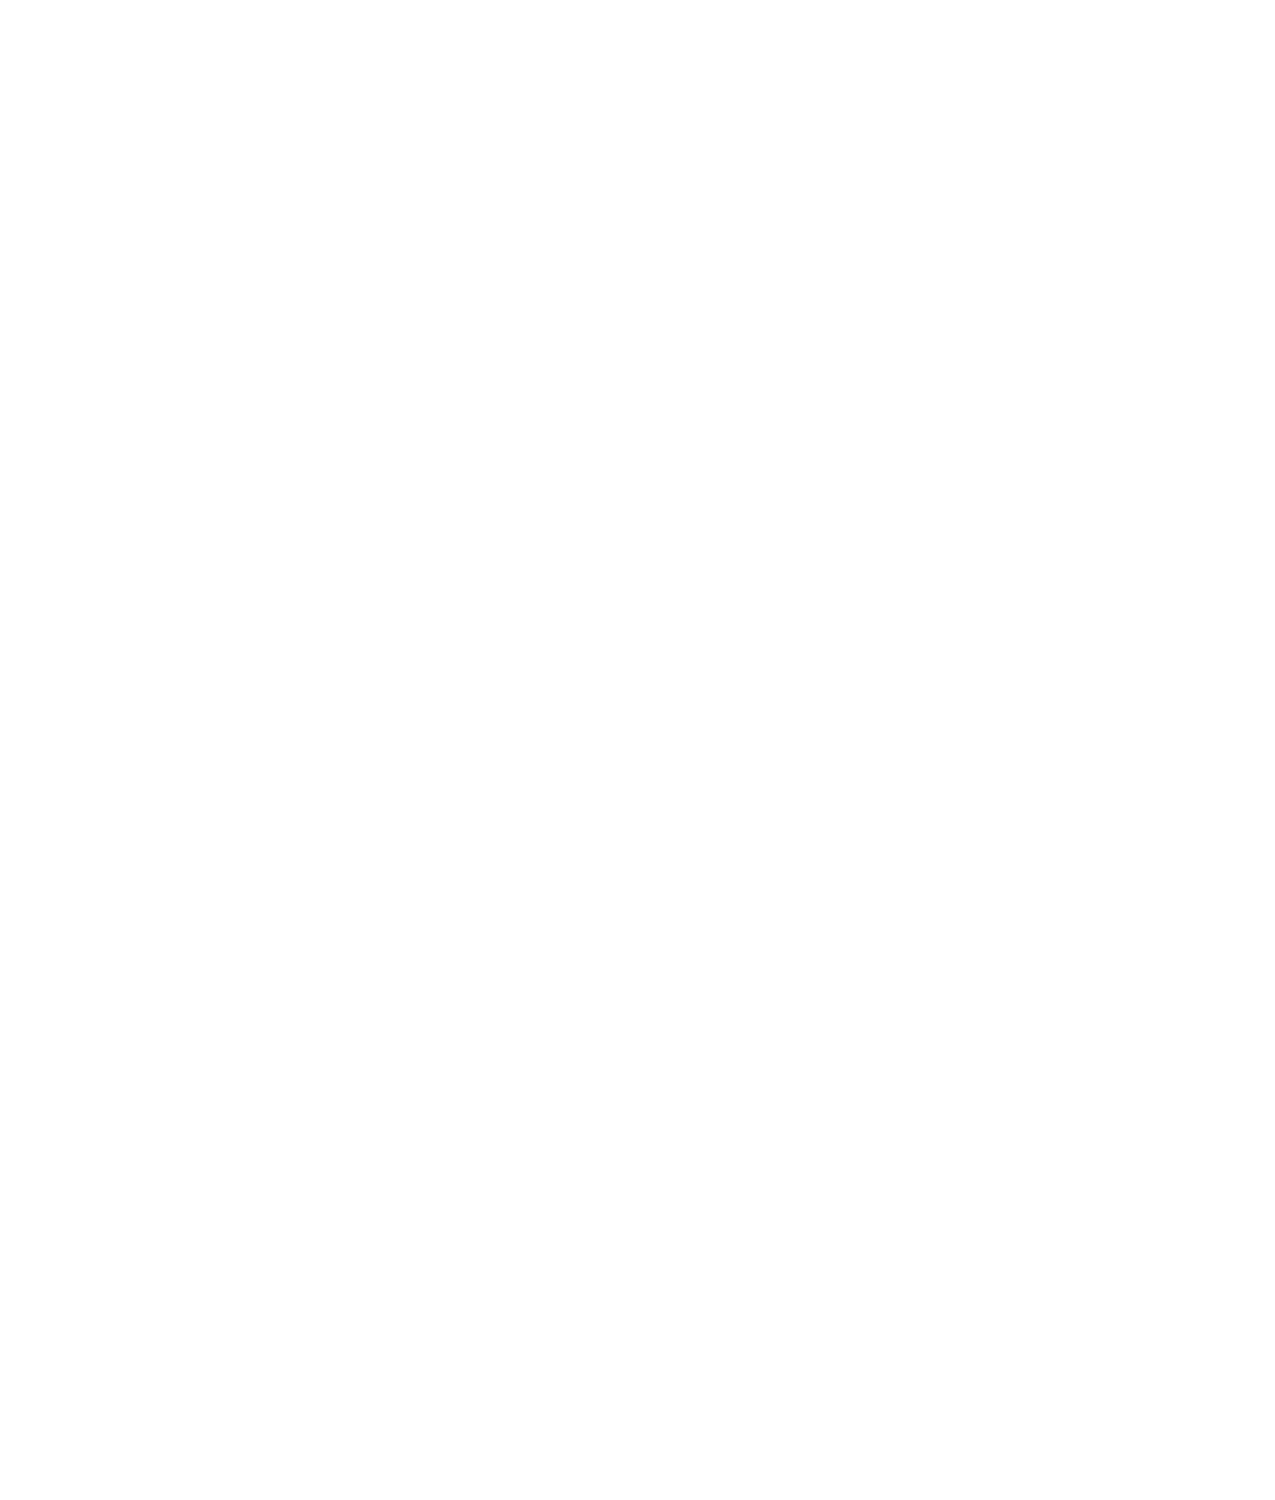

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


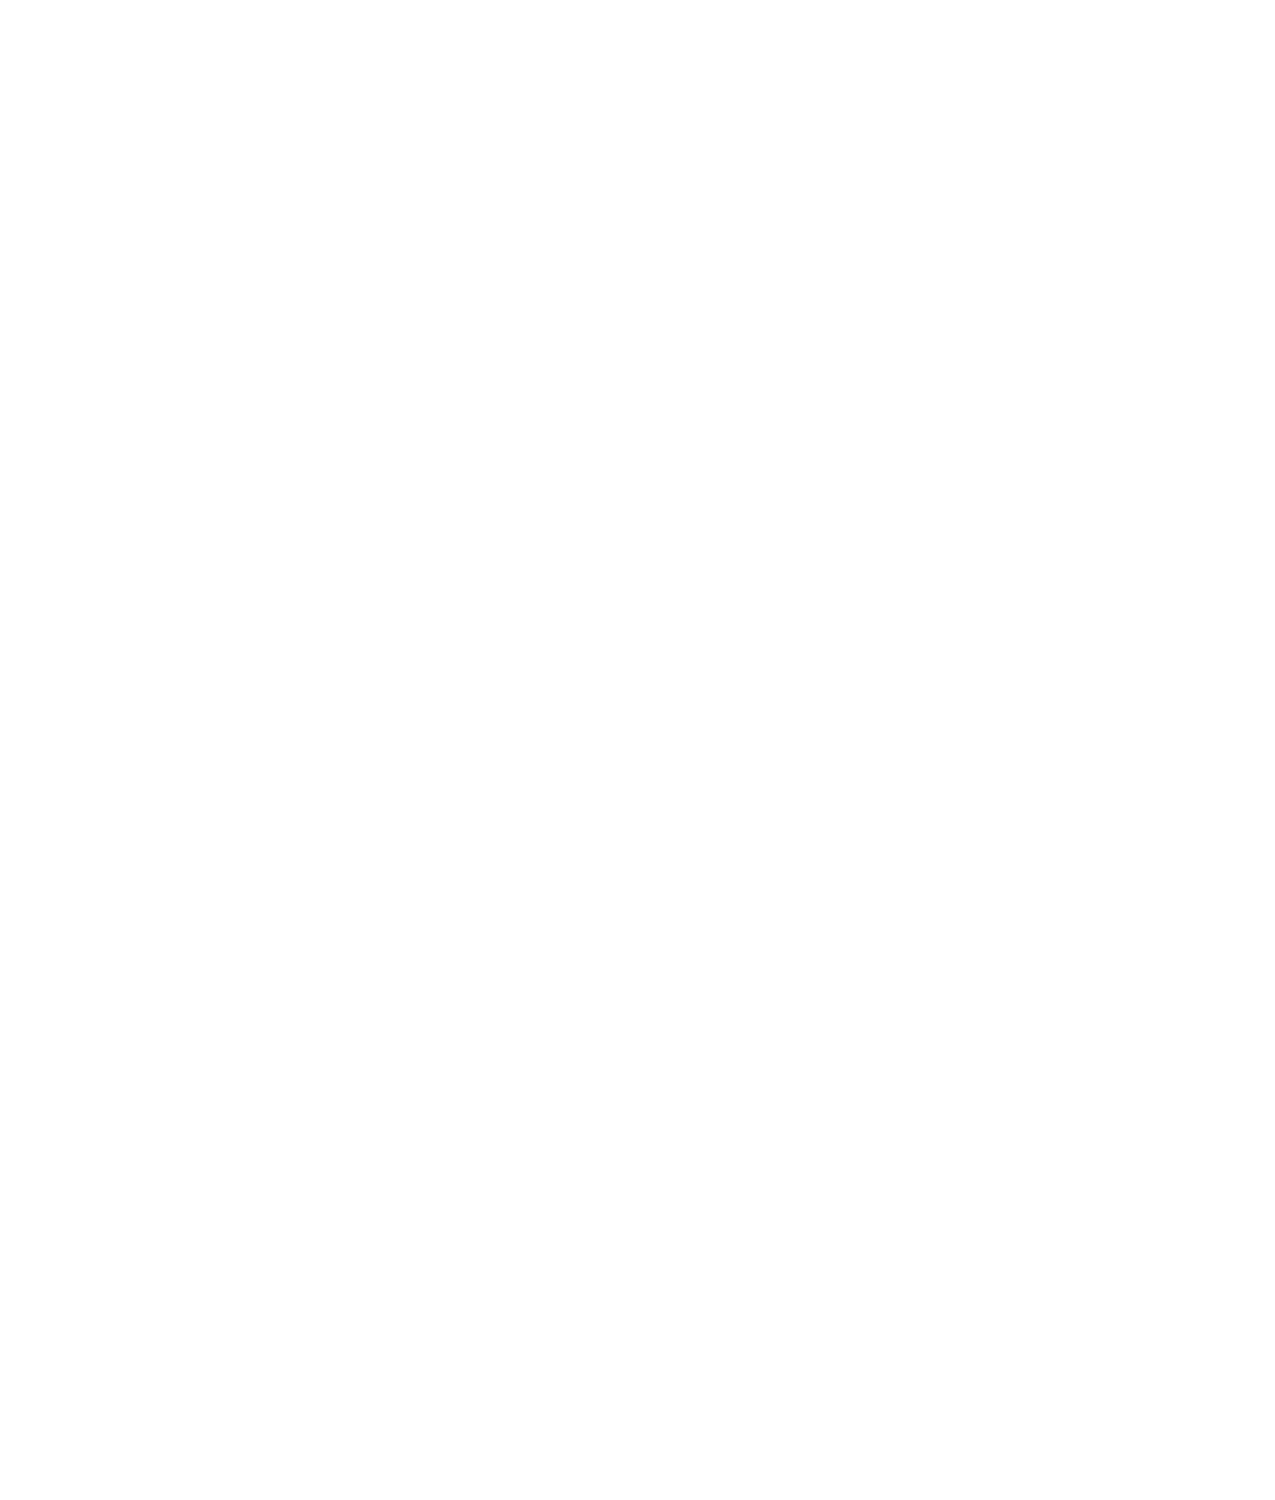

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


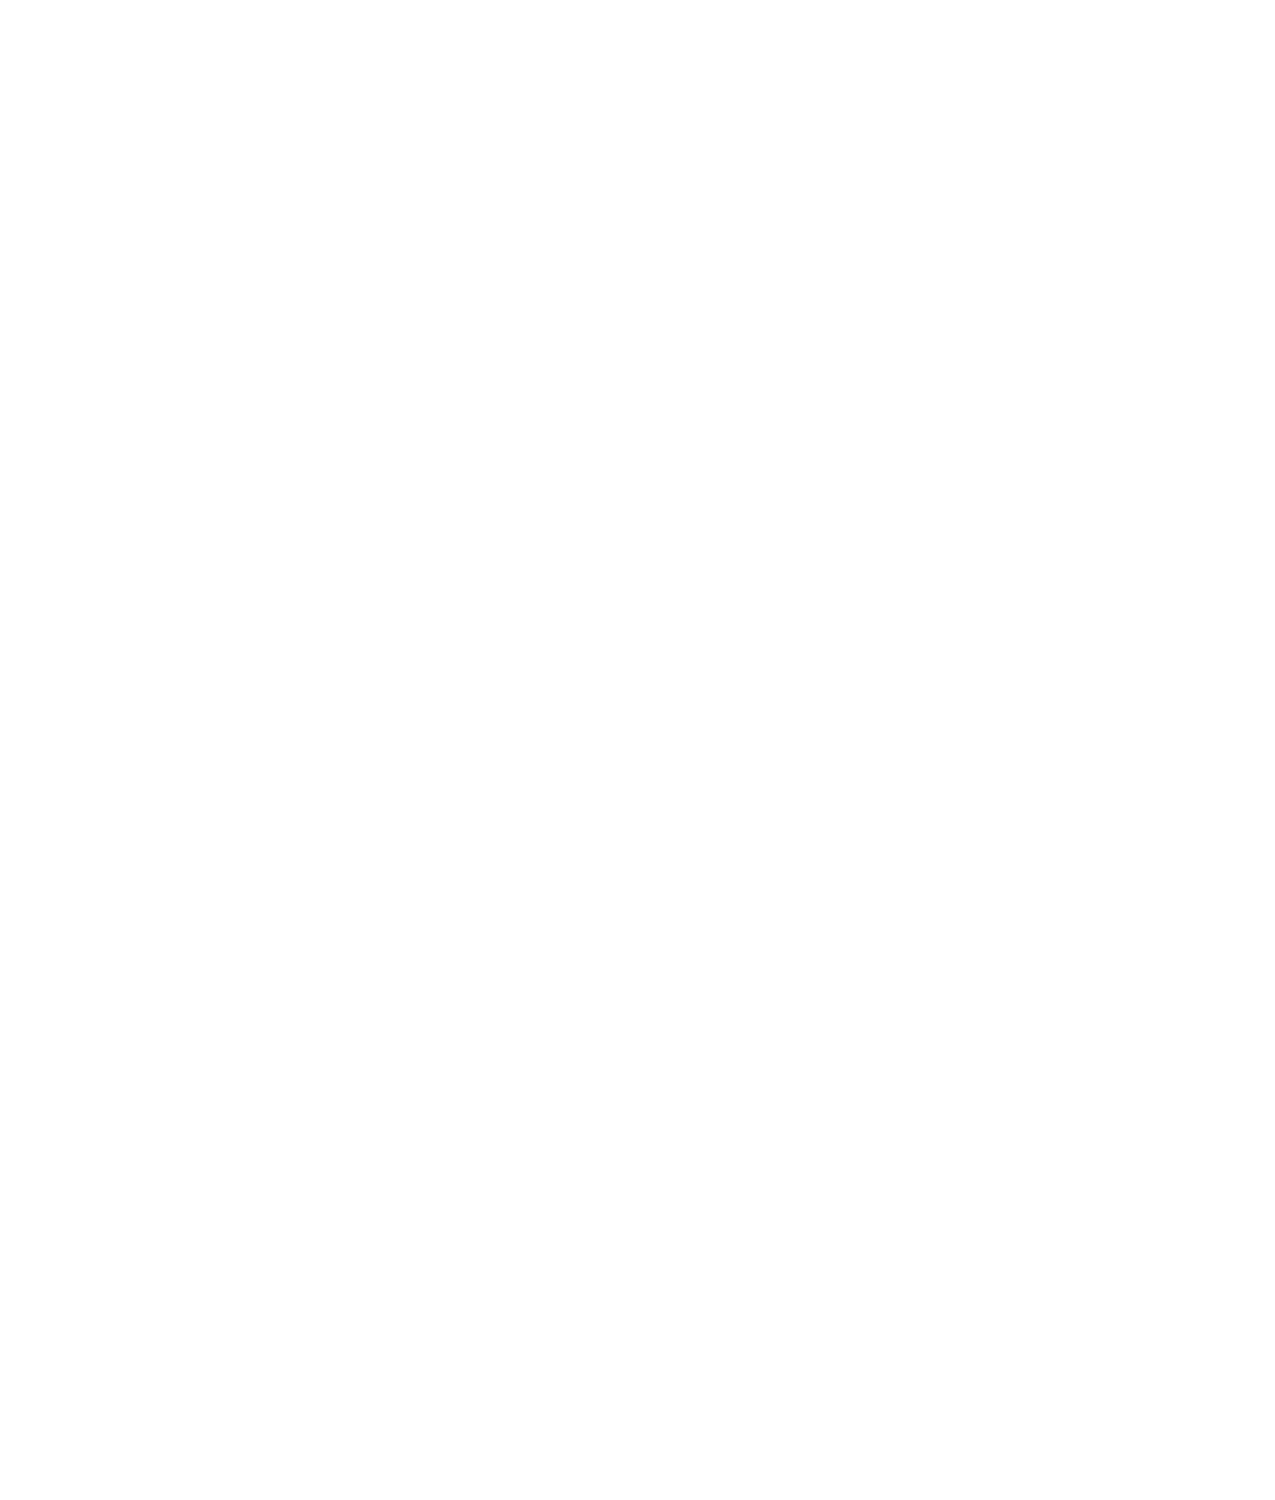

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


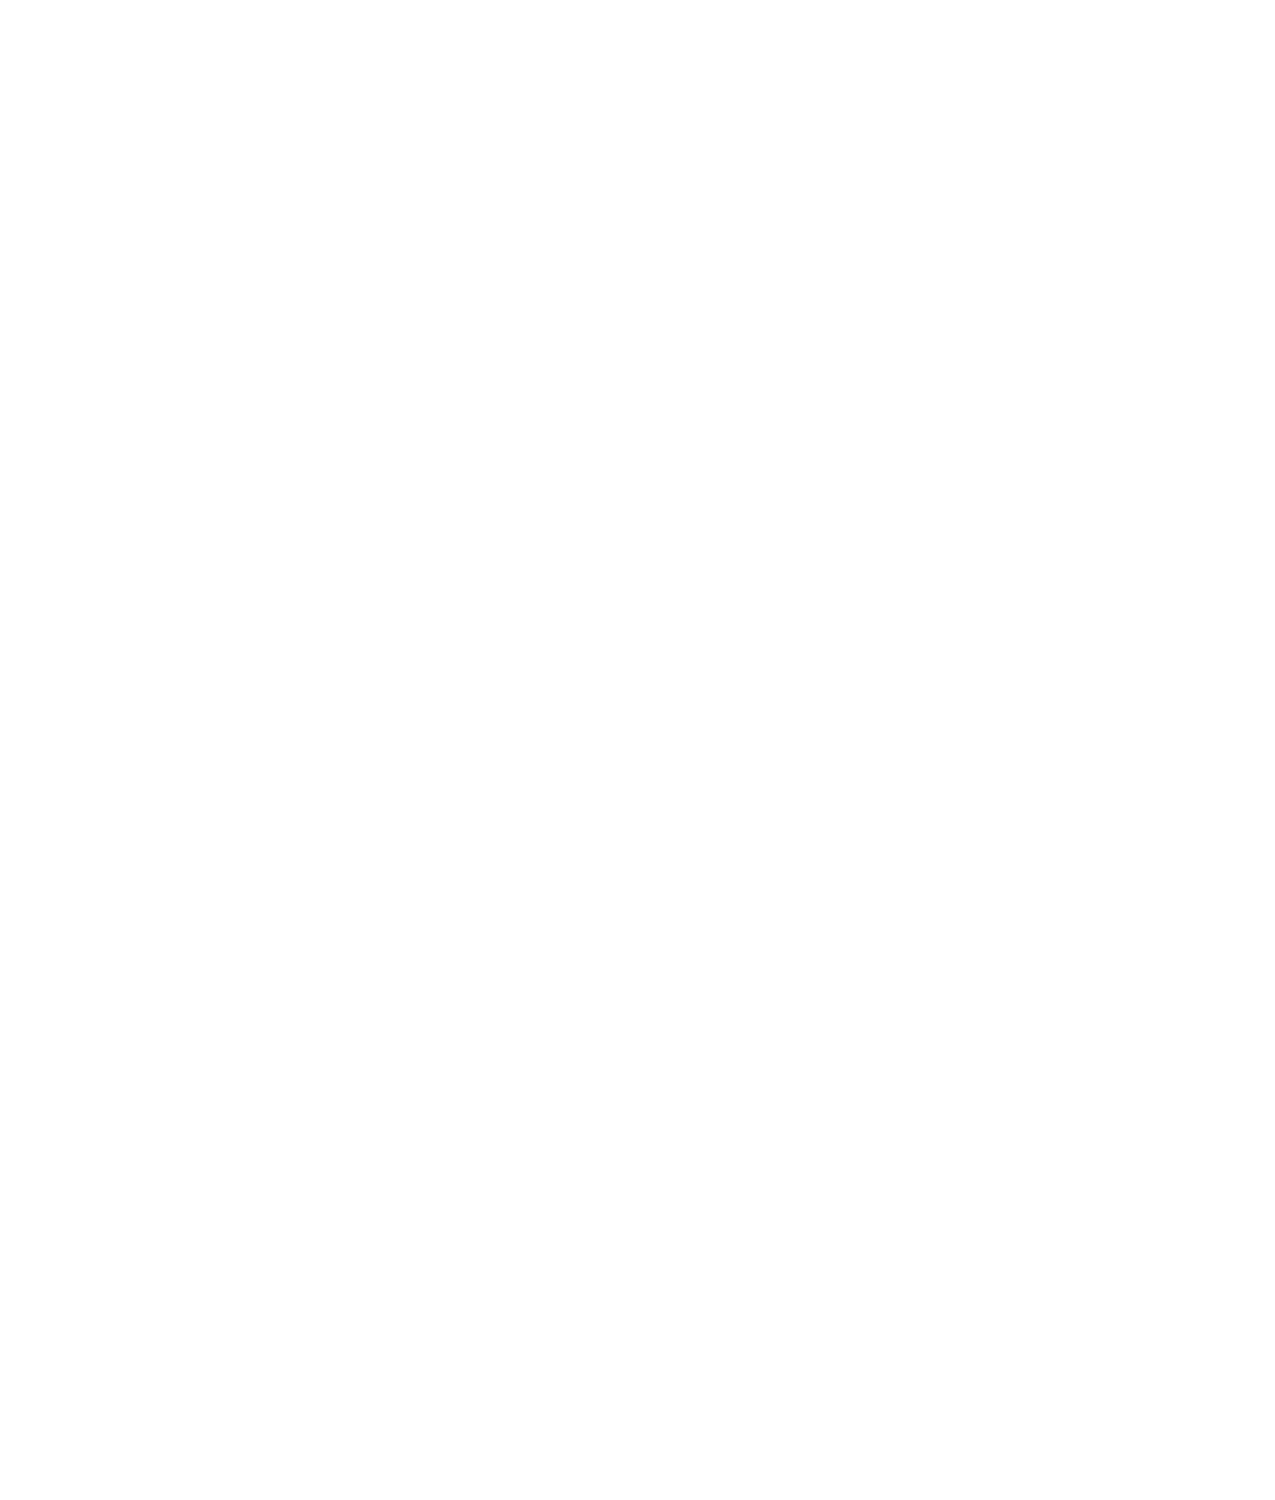

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


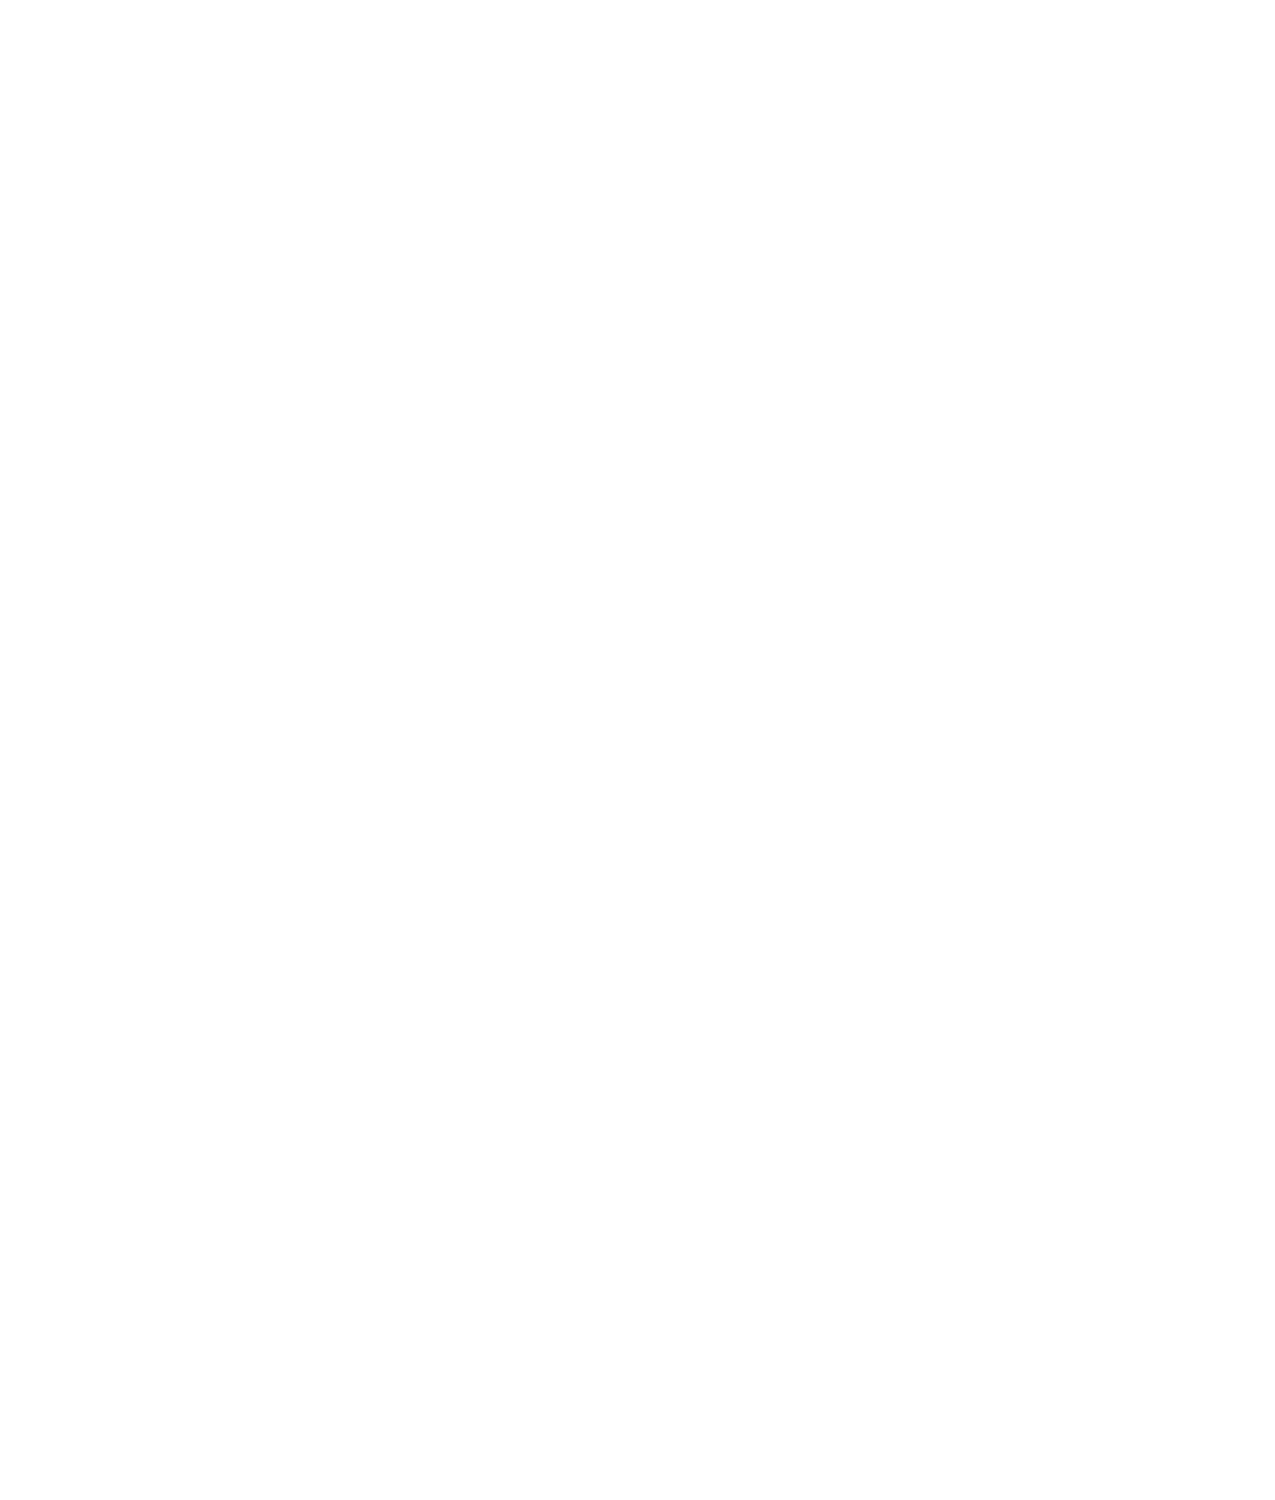

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


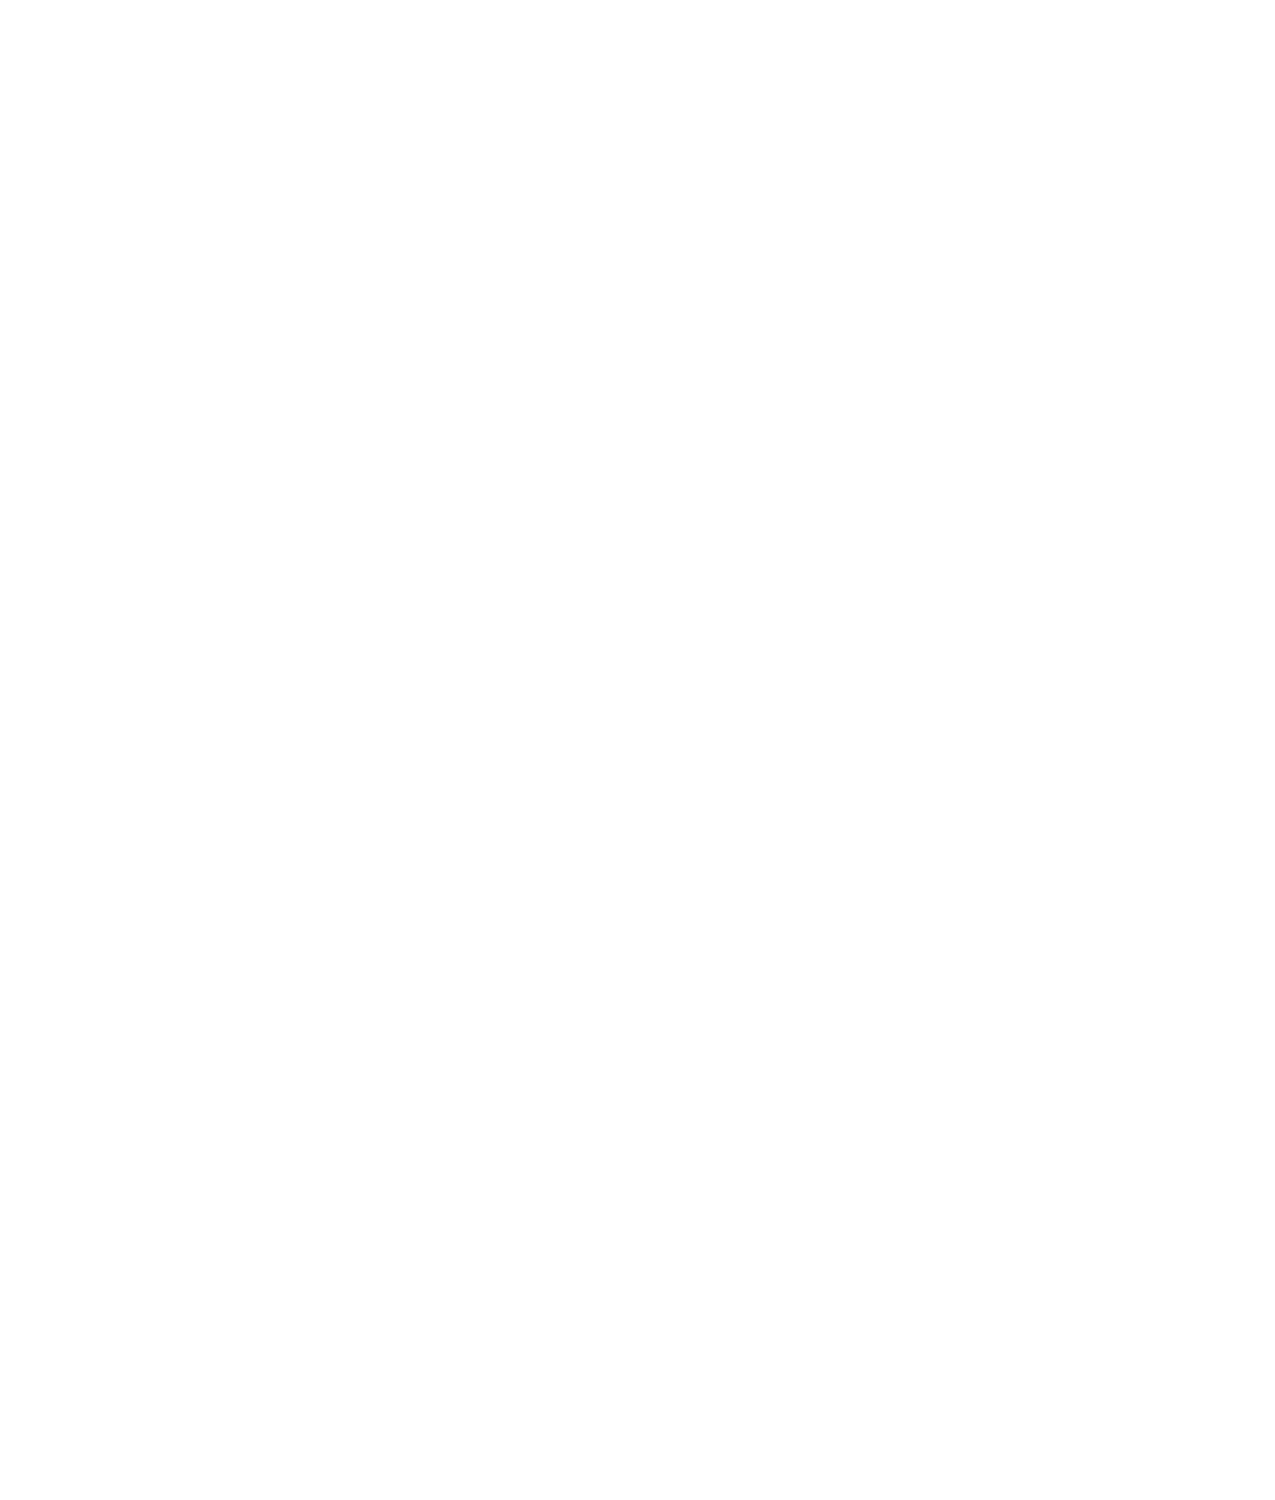

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


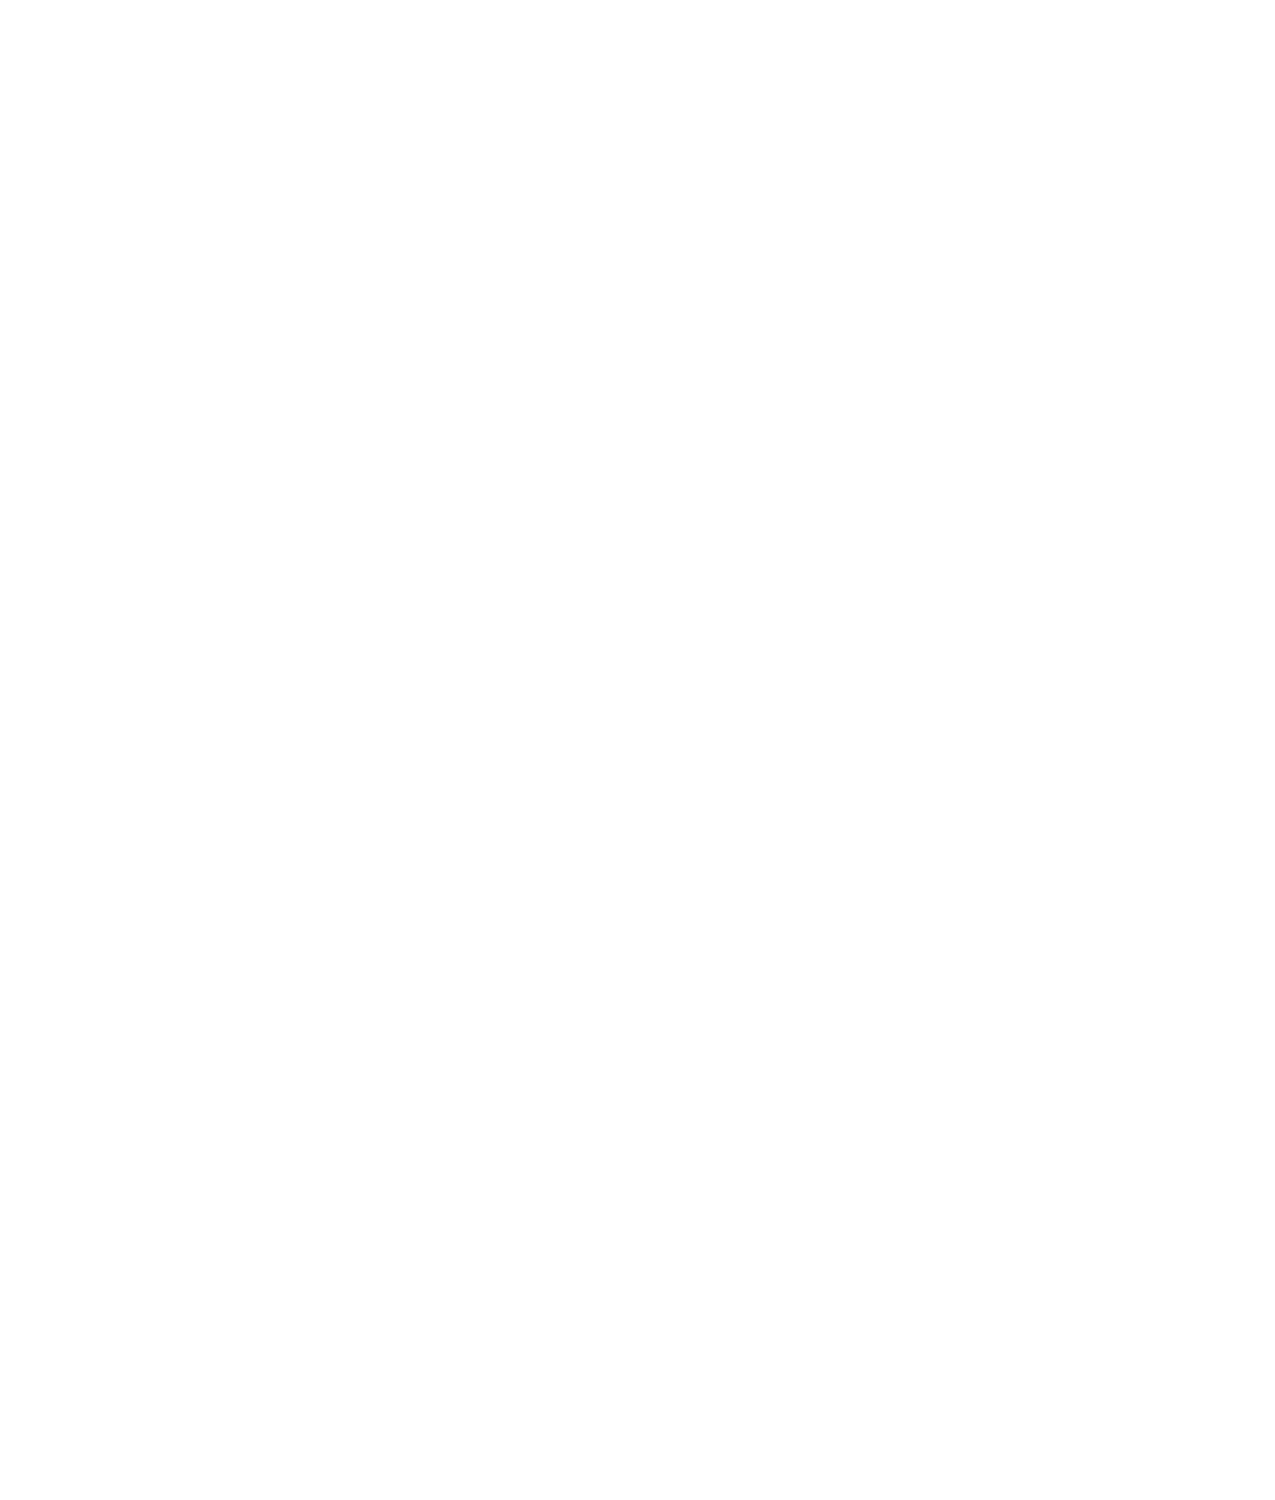

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


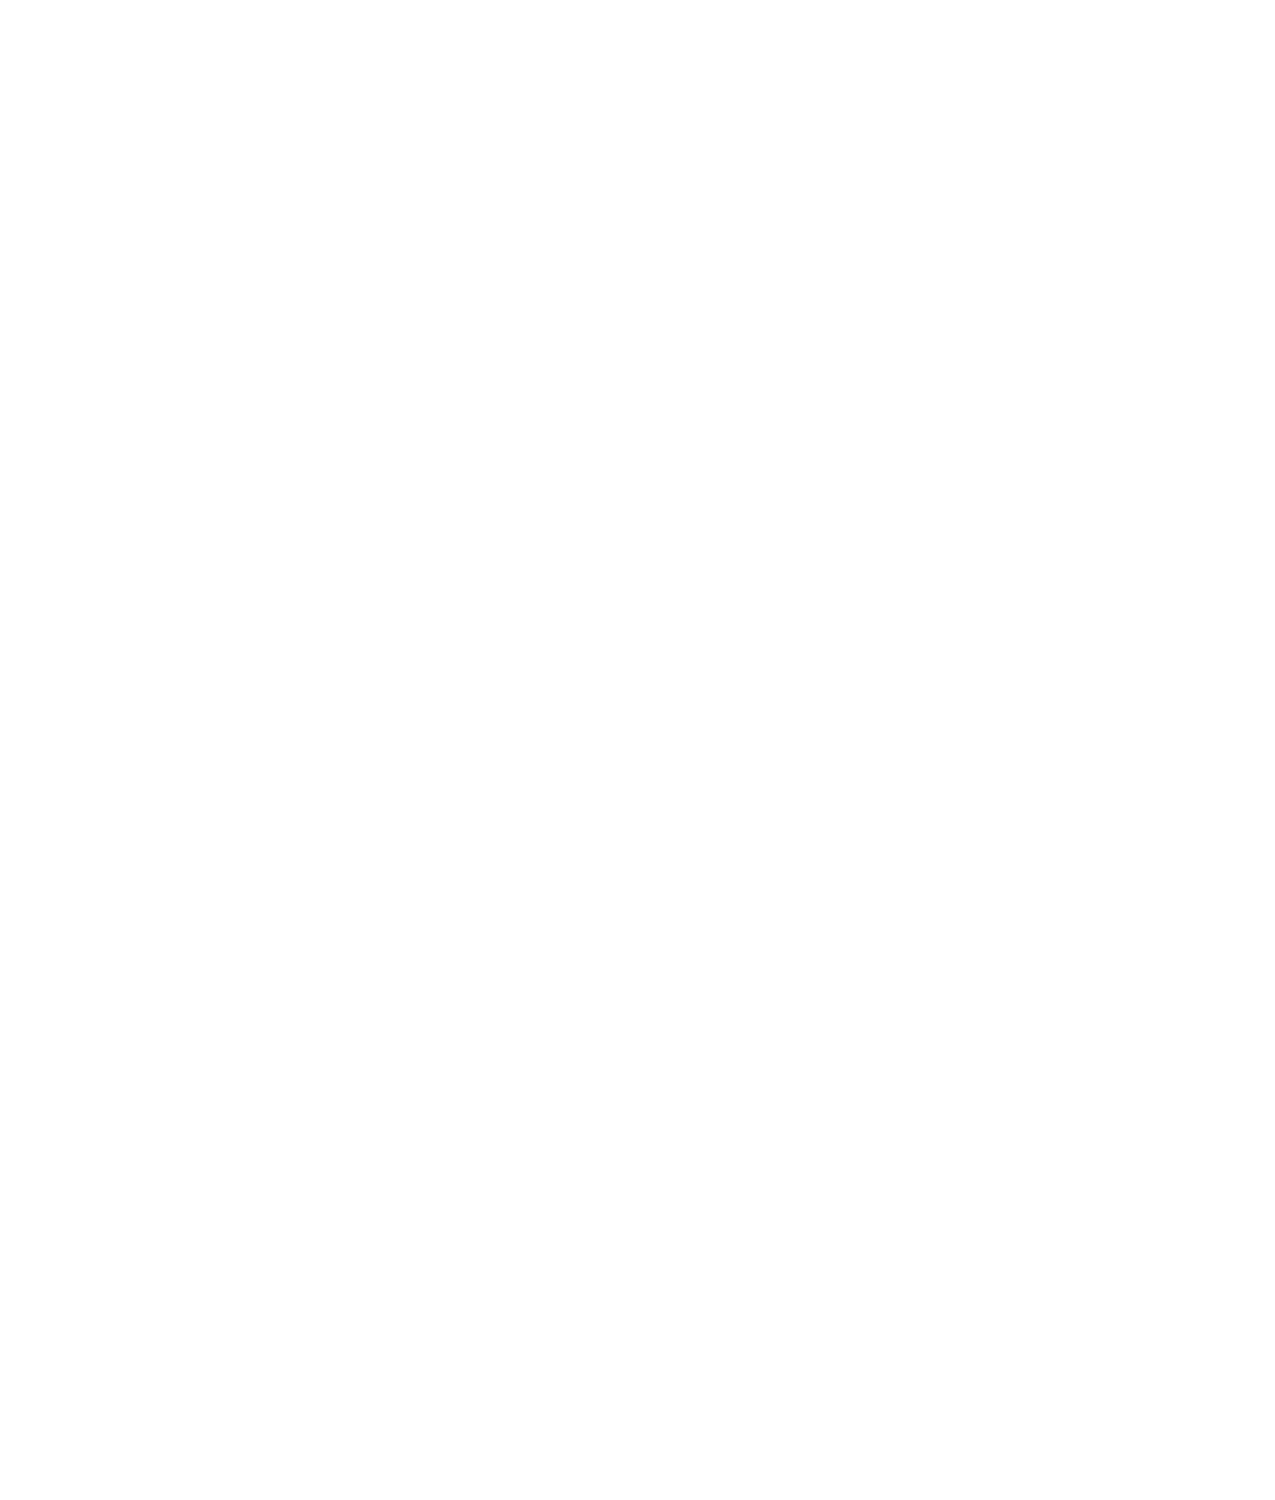

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


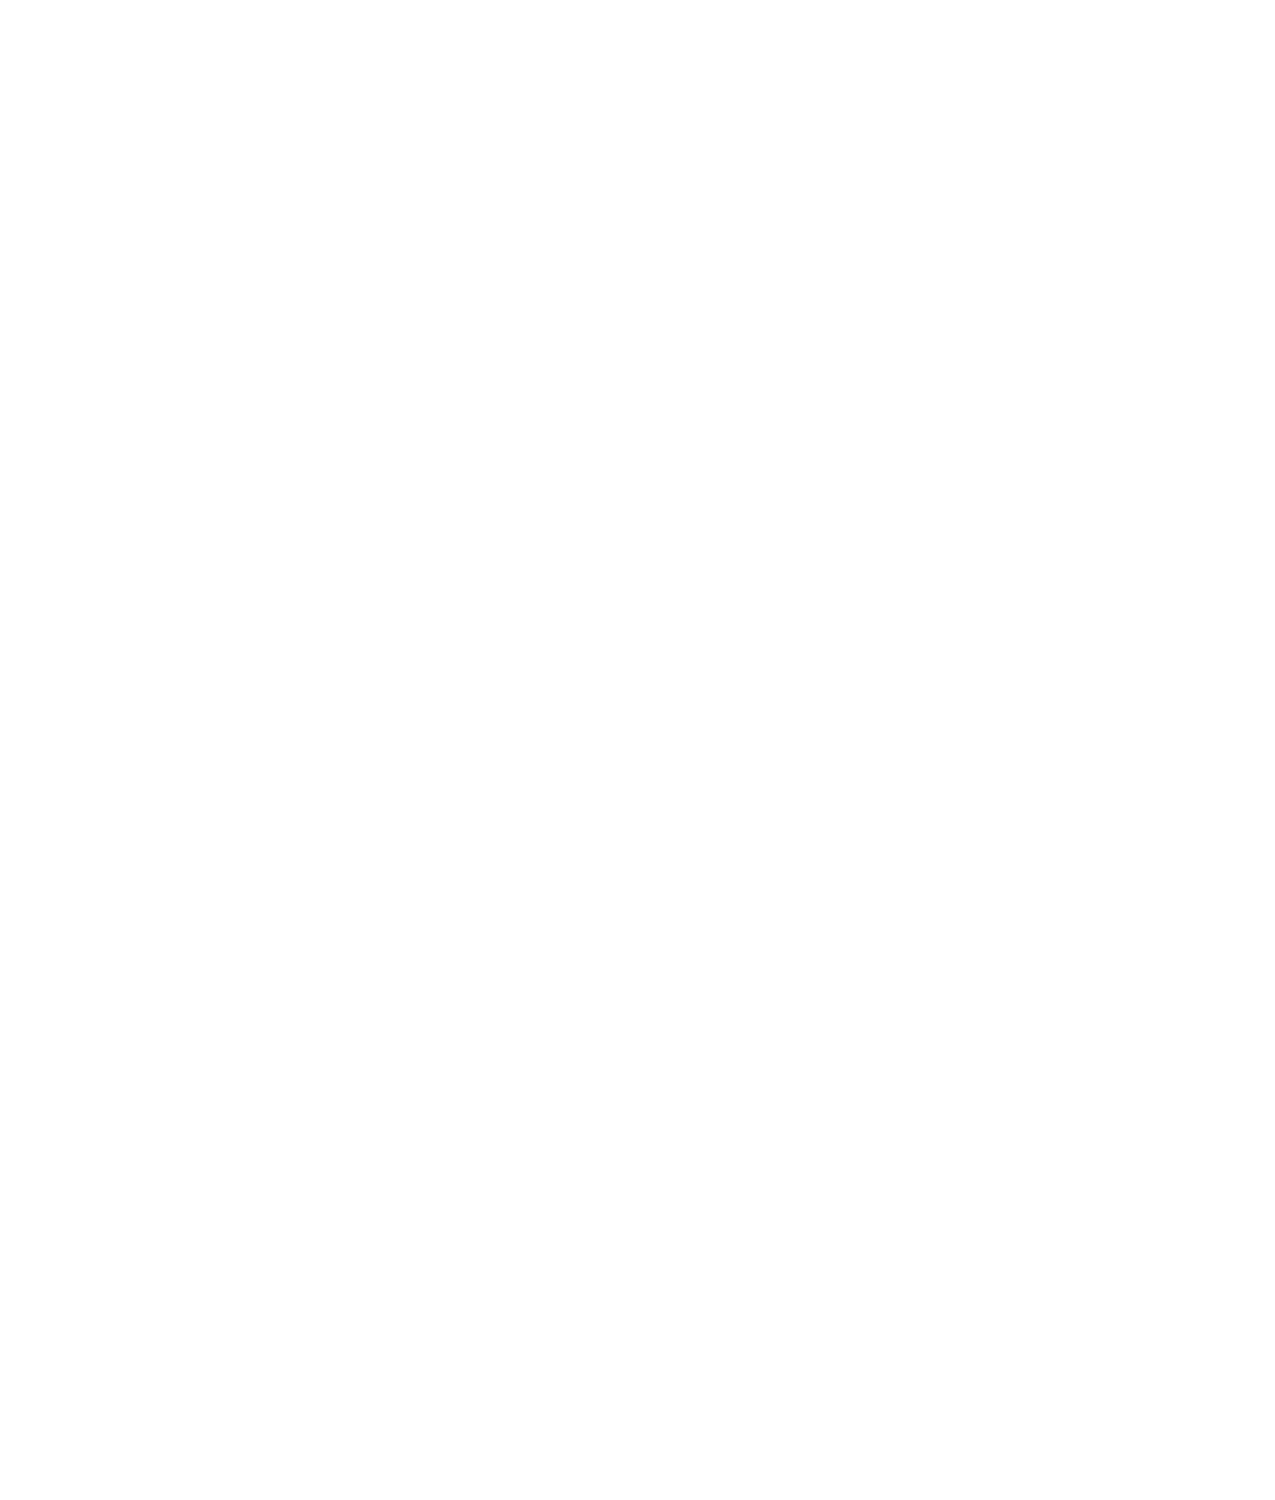

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


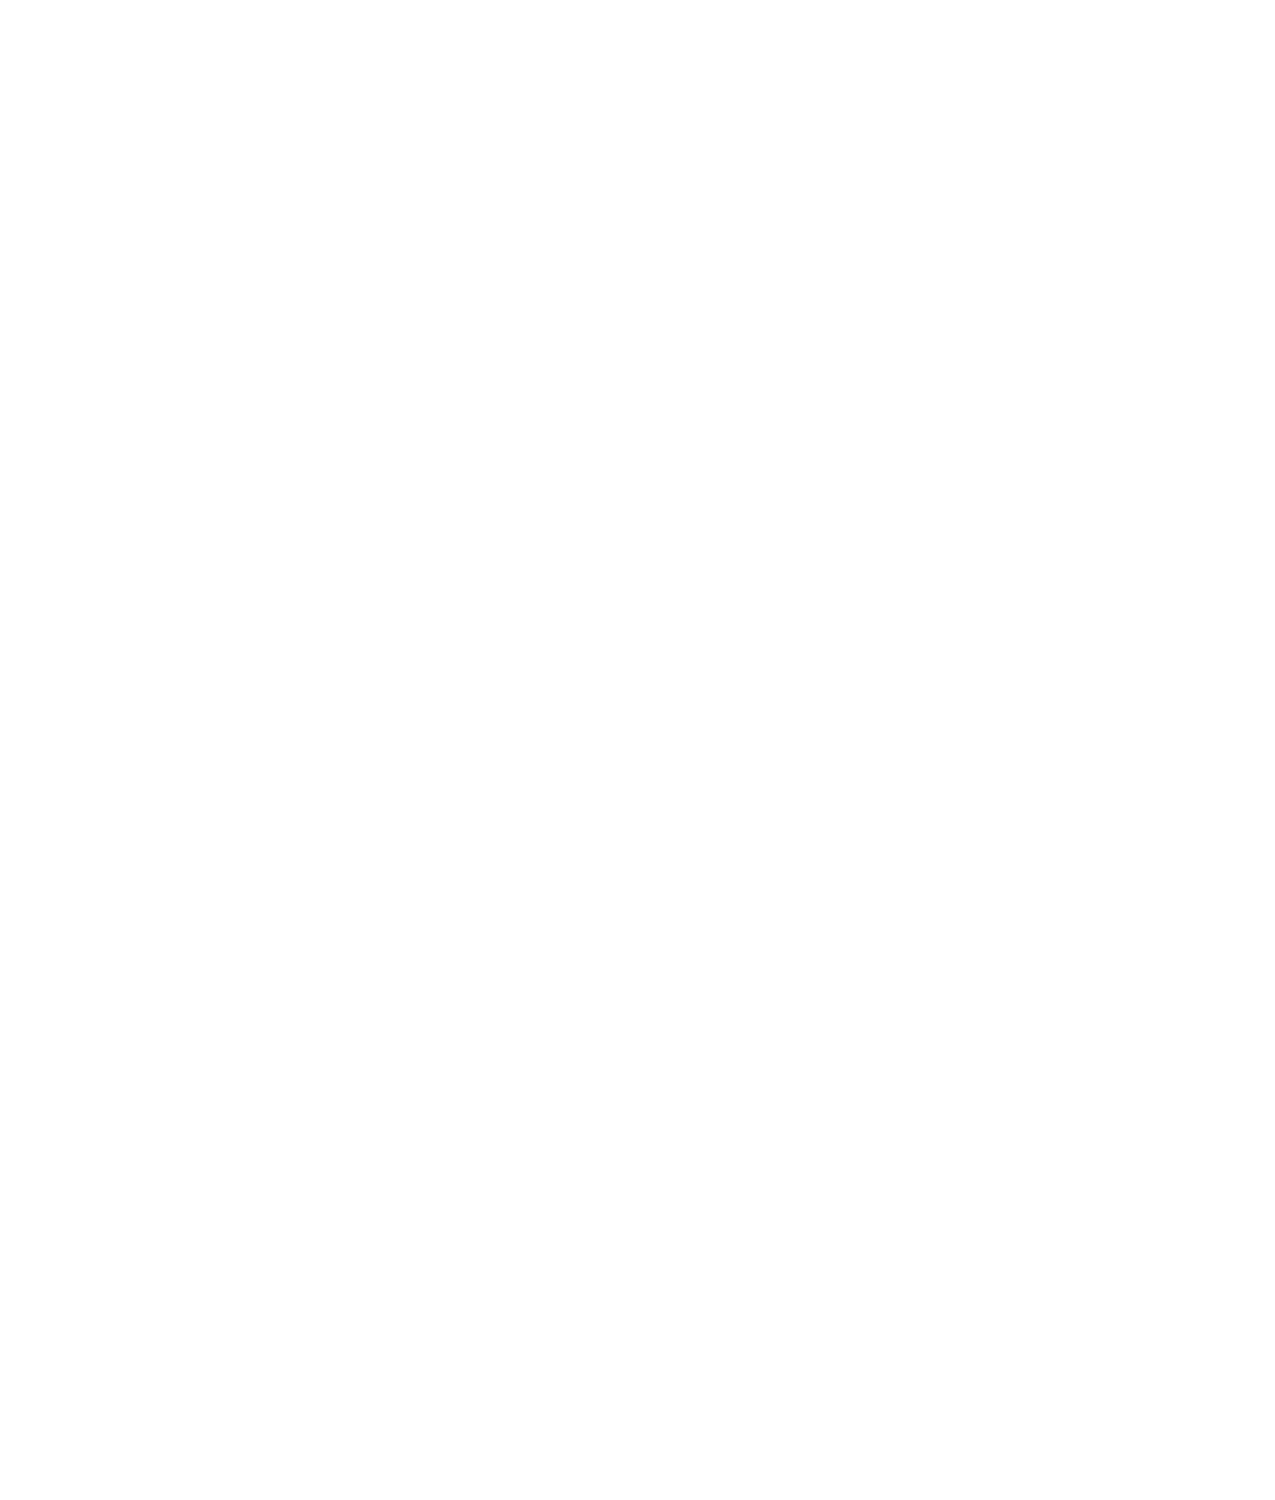

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


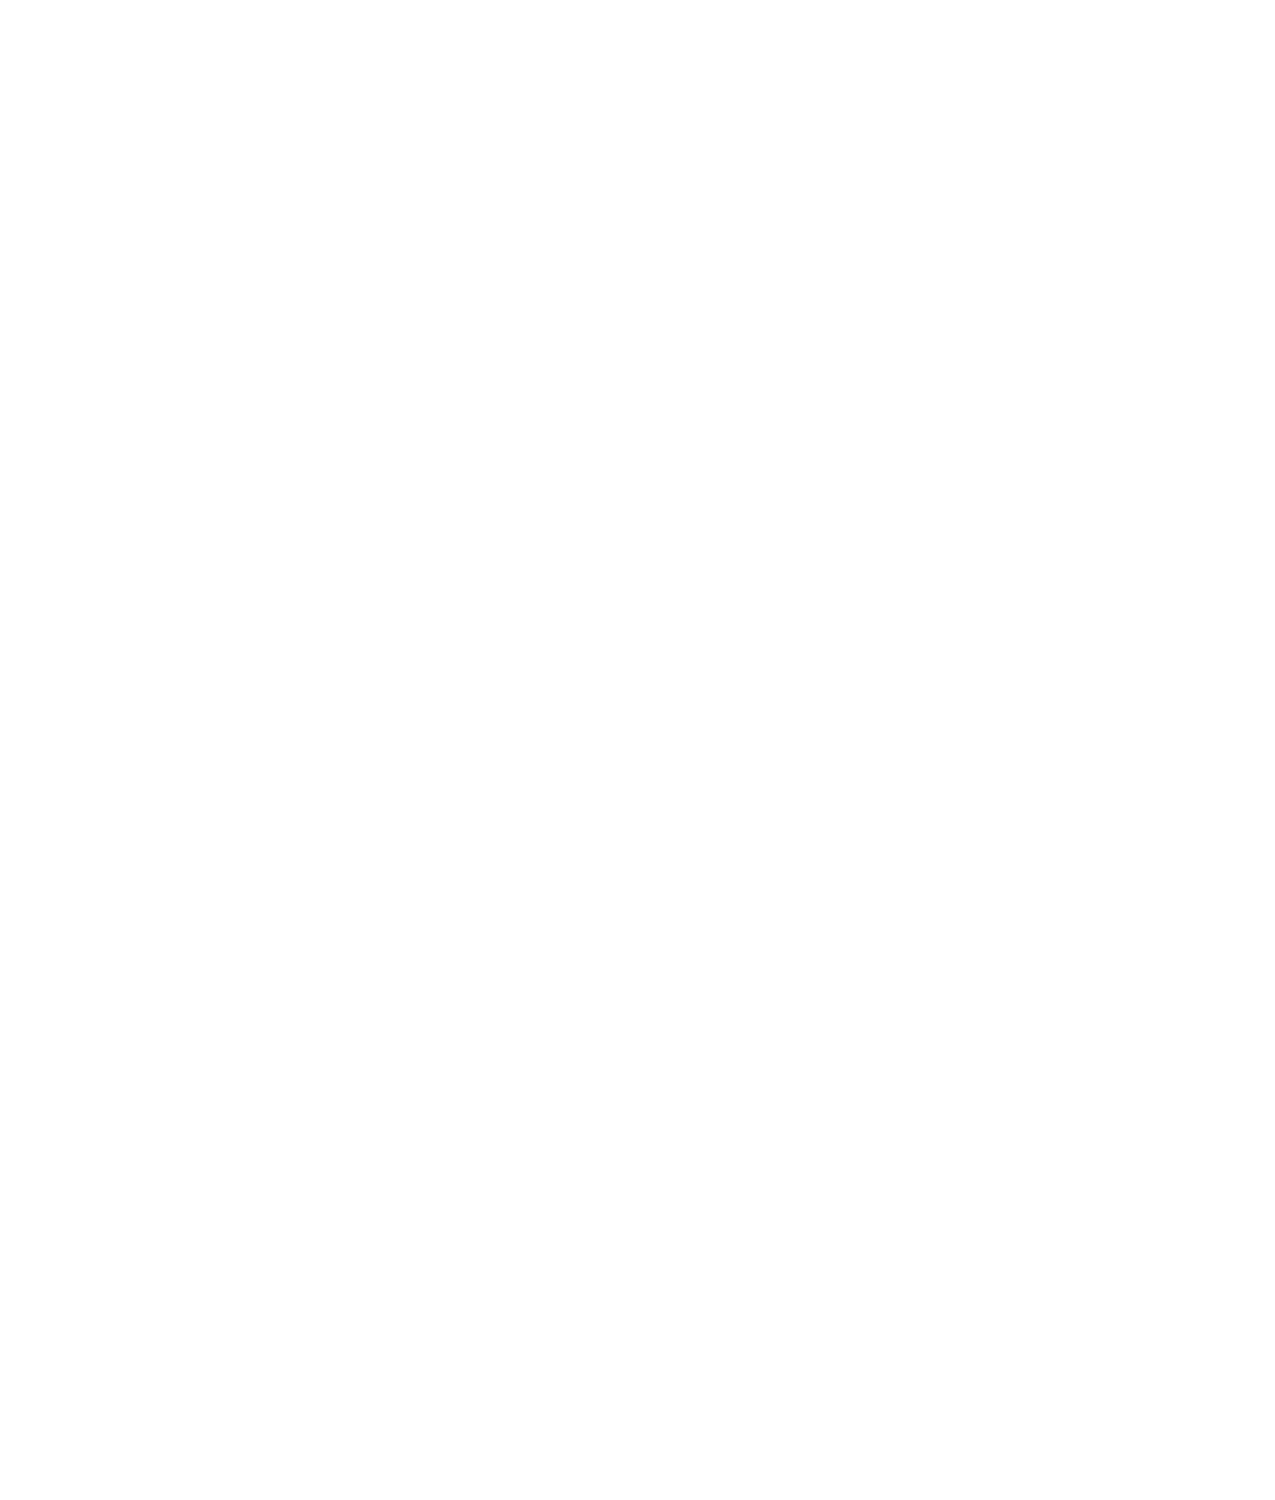

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


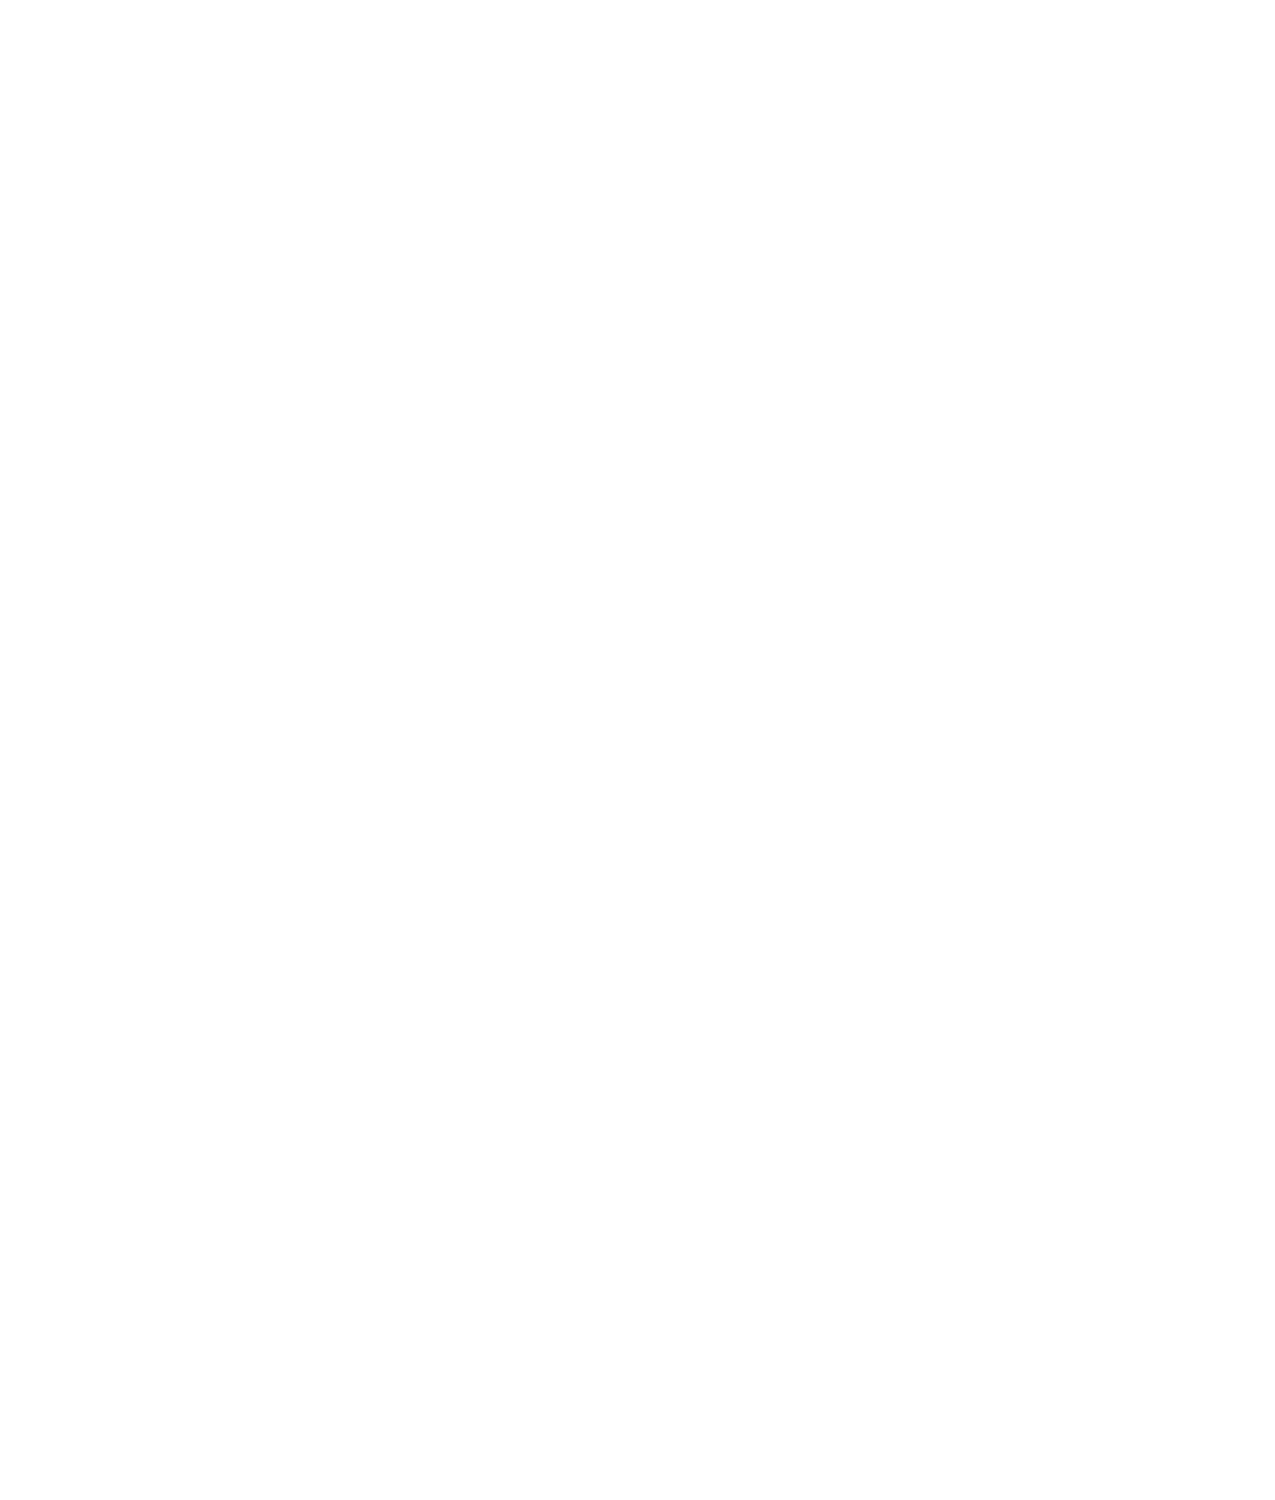

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


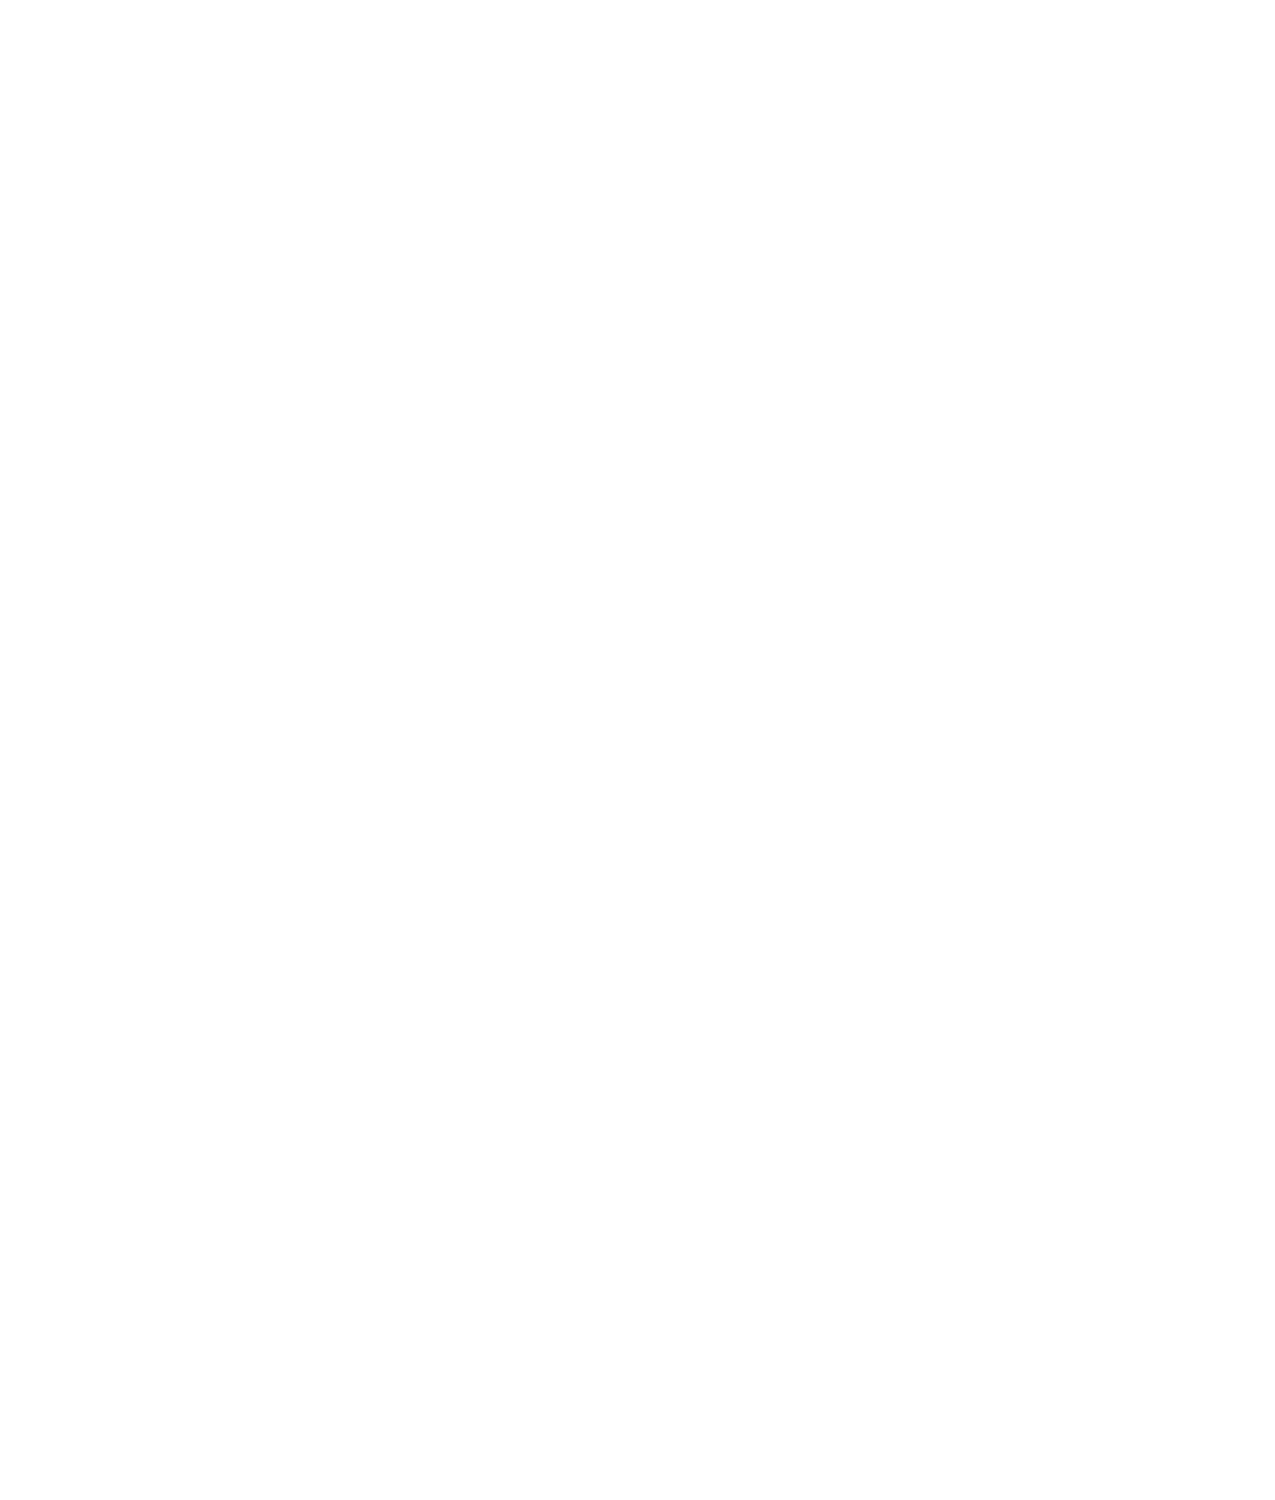

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


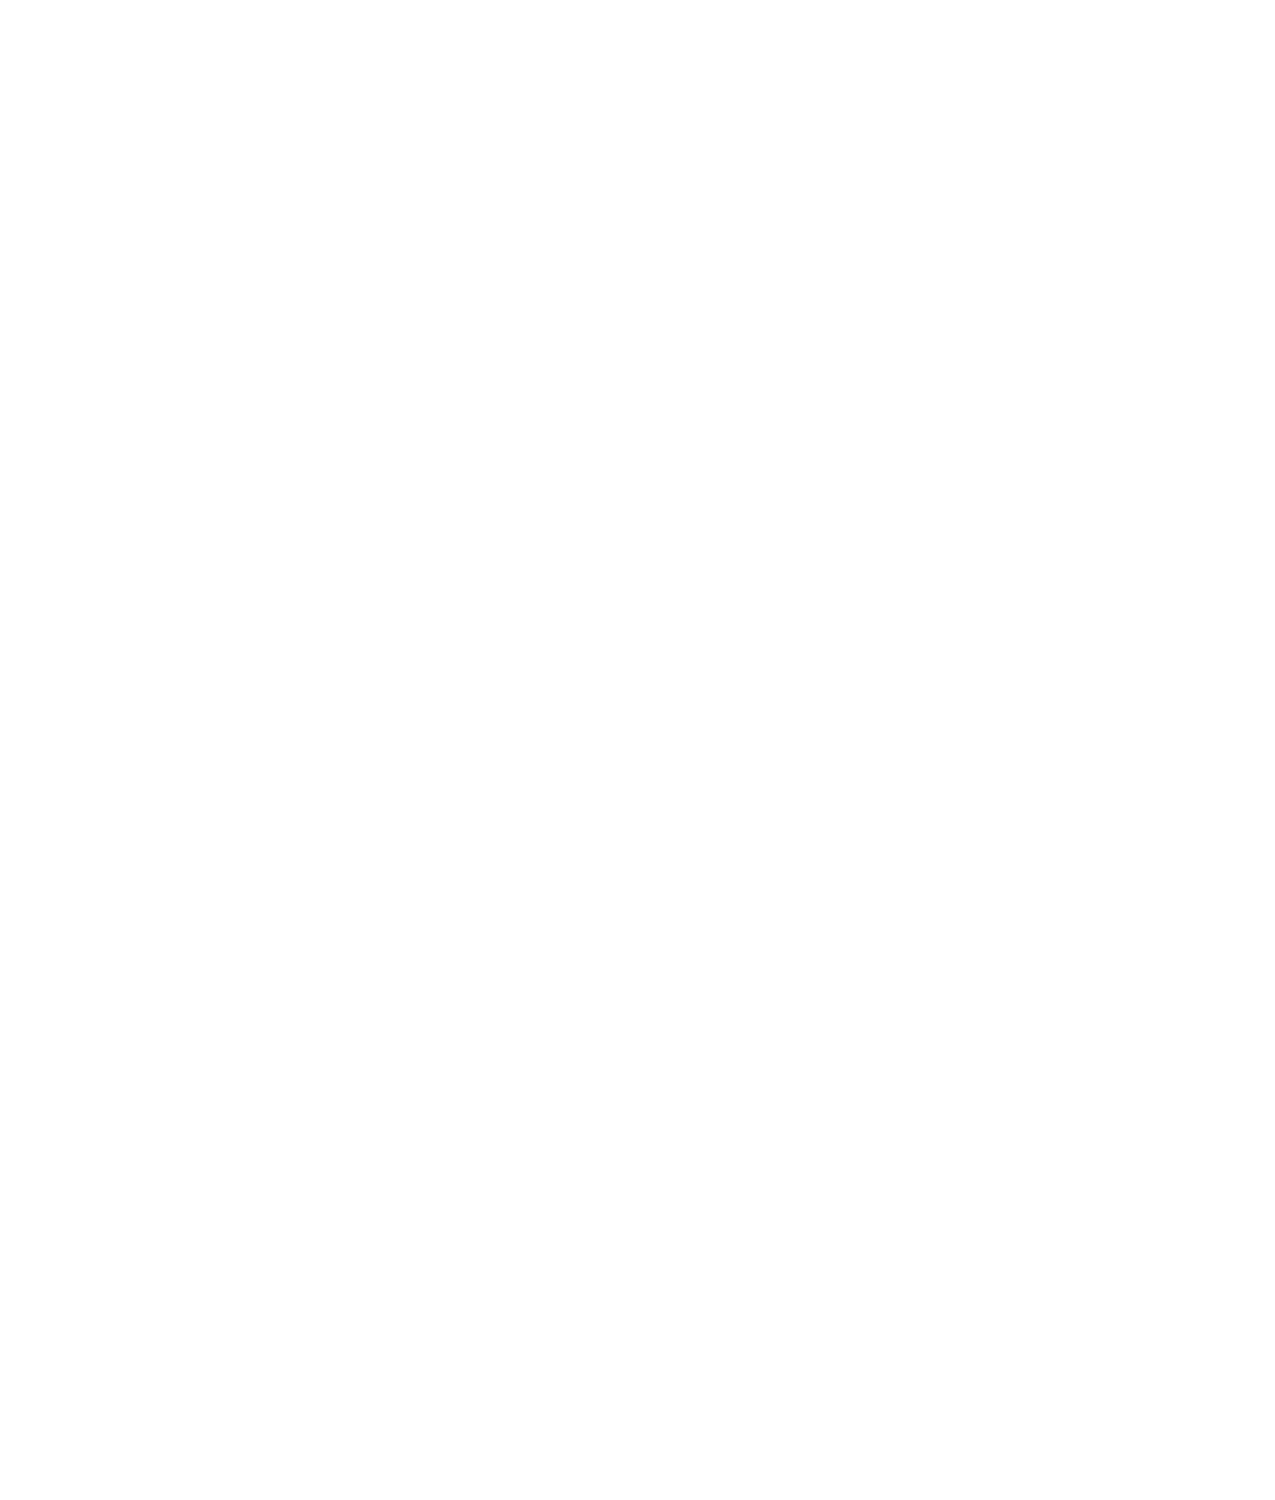

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


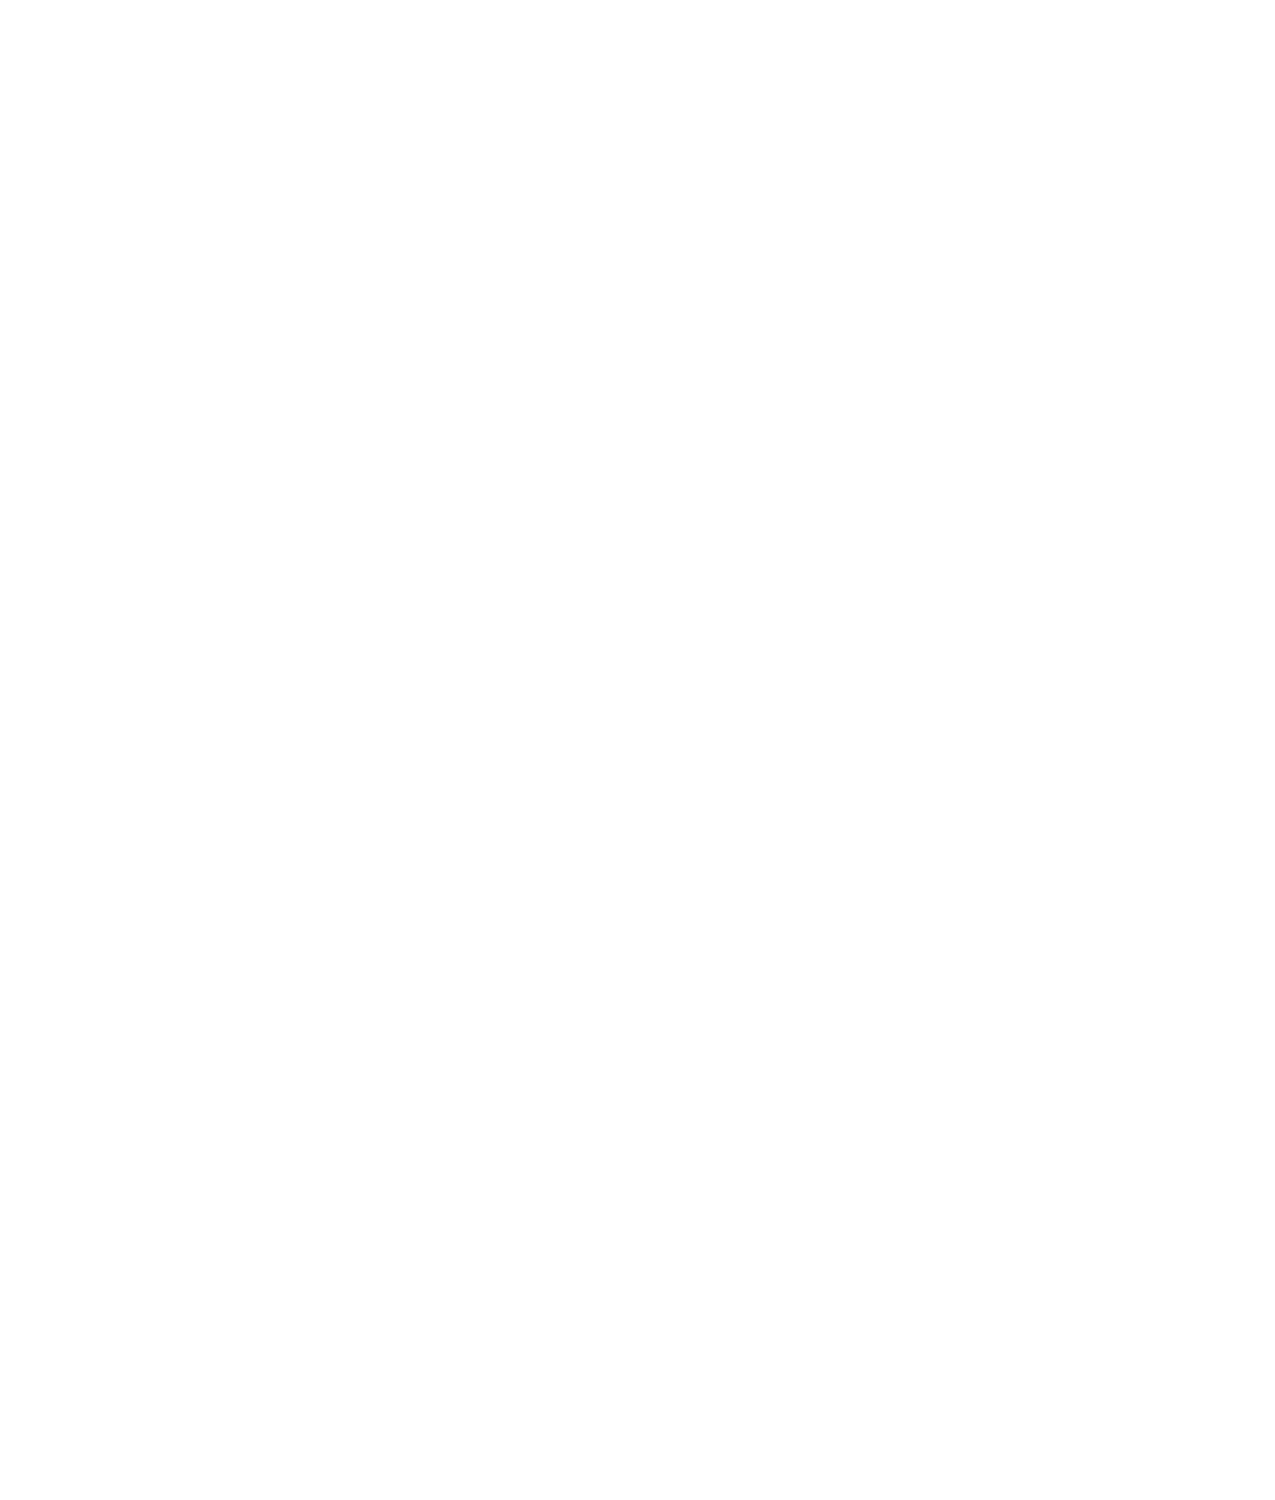

2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


<IPython.core.display.Javascript object>


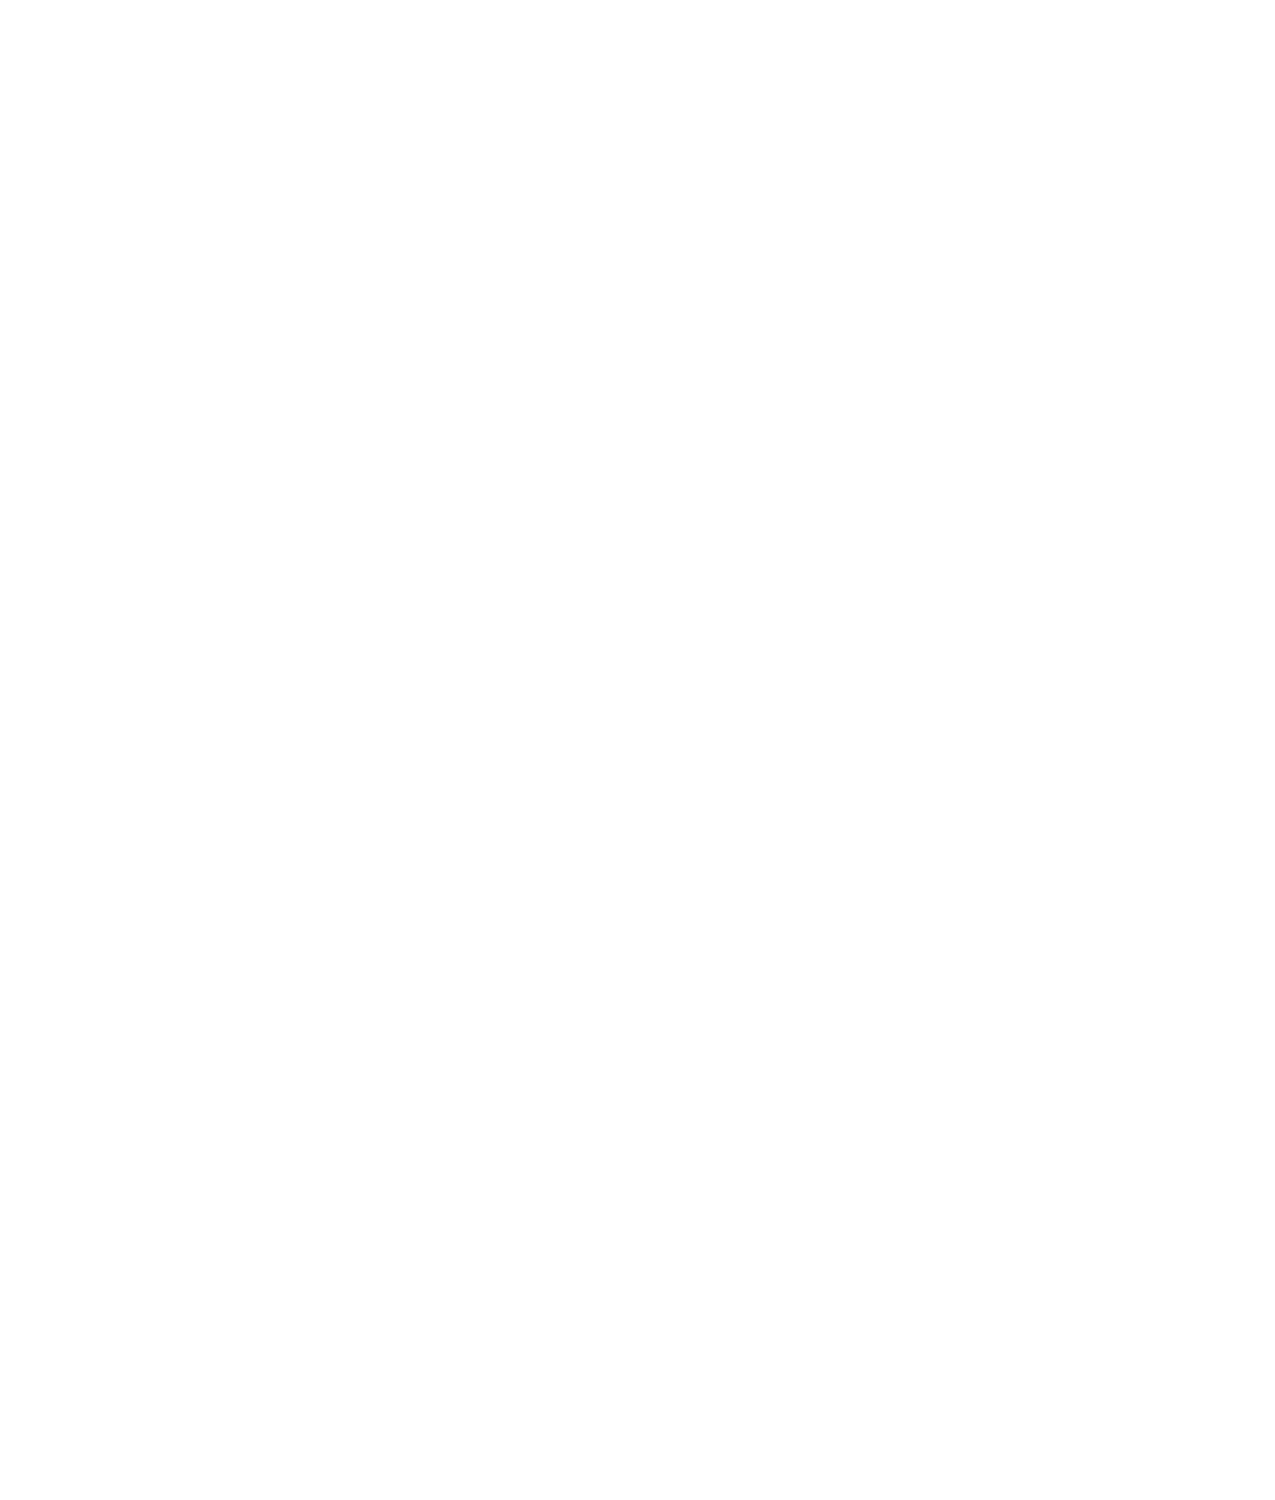

2
3
2
3
2
3
2
3


In [82]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

f = list(zip(x_y_start, x_y_end))

# pdf = PdfPages( ion_tag + '_' + 'fits' + '_3comp_' +str(x_y_start[0])+str(x_y_start[1])+'_'+str(x_y_end[0])+str(x_y_end[1])+'.pdf')

wind = 0
for x in range(0,size_x):
    for y in range(0,size_y):
        
        if wind == 0:
               fig = plt.figure(figsize=(8.5,10.0))
               gs = gridspec.GridSpec(4,4)
               gs.update(left=0.12, right=0.90, top=0.98, bottom=0.08,hspace=0.08)
        ax1 = plt.subplot(gs[wind,0])        
        ne = Spaxel(path_2comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')
        plot_spaxel_pdf(ne, str(x_y_start[0]+x+1), str(x_y_start[1]+y+1), pr= True)
        ax1.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
            
        ax2 = plt.subplot(gs[wind,1])        
        ne = Spaxel(path_3comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')
        plot_spaxel_pdf(ne, str(x_y_start[0]+x+1), str(x_y_start[1]+y+1))
        plt.yticks(())
        ax2.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
            
        ax3 = plt.subplot(gs[wind,2])        
        ne = Spaxel(path_2comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')   
        ne.plot_line_vel_pdf(ion_line, ion_wave_1, z, vel_lim[0], vel_lim[1]        ,str(x_y_start[0]+x+1),str(x_y_start[1]+y+1)) #, snr_c1[x_y_start[1]+y][x_y_start[0]+x], snr_c2[x_y_start[1]+y][x_y_start[0]+x], sn=True)

        plt.yticks(())
        ax3.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
            
        ax4 = plt.subplot(gs[wind,3])        
        ne = Spaxel(path_3comp_fit + 'F05189_00' + str(x_y_start[0]+x+1) +'_00'+ str(x_y_start[1]+y+1) + '.xdr')        
        ne.plot_line_vel_pdf(ion_line, ion_wave_1, z,  vel_lim[0], vel_lim[1]       ,str(x_y_start[0]+x+1),str(x_y_start[1]+y+1)) #, snr_c1[x_y_start[1]+y][x_y_start[0]+x], snr_c2[x_y_start[1]+y][x_y_start[0]+x], sn=True)
        ax4.yaxis.set_label_position('right')
        ax4.yaxis.tick_right()
        ax4.tick_params(labelsize=8)
        if (wind !=3):
            plt.xticks(())
        
        
        if wind == 3:
            plt.savefig(pdf, format='pdf',bbox_inches='tight')
            plt.close()
            wind = 0
        else:
            wind = wind + 1

if wind == 1 or wind == 2 or wind == 3:
    plt.savefig(pdf, format='pdf',bbox_inches='tight')
    plt.close()
pdf.close()    
        

In [55]:
data = readsav(path_2comp_fit + 'F05189_00' + str(45) +'_00'+ str(45) + '.xdr')
print(data['struct']['parinfo'][0]['line'])
print(data['struct']['parinfo'][0]['comp'])

['' '' '' '' '' '' '' '' '' '' '' '' '' b'[OIII]4959' b'[OIII]4959'
 b'[OIII]4959' b'[OIII]5007' b'[OIII]5007' b'[OIII]5007' b'[OIII]4959'
 b'[OIII]4959' b'[OIII]4959' b'[OIII]5007' b'[OIII]5007' b'[OIII]5007']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2.
 2.]


In [37]:
data = readsav('/raid/KCWI/AGN_outflows/F05189/iter2/' + 'F05189_00' + str(45) +'_00'+ str(45) + '.xdr')
print(data['struct']['parinfo'][0]['line'])

['' '' '' '' '' '' '' '' '' '' '' '' '' b'Hbeta' b'Hbeta' b'Hbeta'
 b'[NeIII]3869' b'[NeIII]3869' b'[NeIII]3869' b'Hgamma' b'Hgamma'
 b'Hgamma' b'[OII]3726' b'[OII]3726' b'[OII]3726' b'[OIII]5007'
 b'[OIII]5007' b'[OIII]5007' b'[OII]3729' b'[OII]3729' b'[OII]3729'
 b'[OIII]4959' b'[OIII]4959' b'[OIII]4959' b'Hbeta' b'Hbeta' b'Hbeta'
 b'[NeIII]3869' b'[NeIII]3869' b'[NeIII]3869' b'Hgamma' b'Hgamma'
 b'Hgamma' b'[OII]3726' b'[OII]3726' b'[OII]3726' b'[OIII]5007'
 b'[OIII]5007' b'[OIII]5007' b'[OII]3729' b'[OII]3729' b'[OII]3729'
 b'[OIII]4959' b'[OIII]4959' b'[OIII]4959']


# Natalie plotting

In [ ]:
# plot_kin(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False)

# plot_kin_c2(idx, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False)
    

In [52]:
def get_variable_OIII(idx_f, idx_v, arr, arr2, arr3):
    f = copy(arr[idx_f][1])
    f_err = copy(arr2[idx_f][1])
    f = set_bad(f)
    f_err = set_bad(f_err)
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    v = copy(arr3[idx_v][1])
    v = set_bad(v)
    v = set_sn(sn,v)
    return v

def get_sn(idx, arr, arr2):
    f = copy(arr[idx][1])
    f_err = copy(arr2[idx][1])
    f = set_bad(f)
    f_err = set_bad(f_err)
    for row in range(f_err.shape[0]):
        for column in range(f_err.shape[1]):
            if(f_err[row][column] < err_thresh):
                f_err[row][column] = err_thresh
    
    sn = f/f_err  
    sn_cut = np.where(sn < 3) #change here the SN threshold, now set to 3
    sn[sn_cut] = nan 
    return sn

In [53]:
###### idx_f and idx_v

def plot_kin_OIII(idx_f, idx_v, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -400, 400,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -1000, 300,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -300, 1000,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)

def plot_kin_c2_OIII(idx_f, idx_v, f_temp, err_f_temp, v50_temp, vsig_temp, v02_temp, v98_temp, spx_x=None, spx_y=None, width=None, height=None, scale=None, spx=False, rec= False):
    figure(figsize=(5,5))
    v50_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v50_temp)
    vsig_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, vsig_temp)
    v02_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v02_temp)
    v98_line = get_variable_OIII(idx_f, idx_v, f_temp, err_f_temp, v98_temp)
       
    subplot(221)
    sub_plot(v50_line, -300, 300,'RdBu_r', spx_x, spx_y, width, height, spx, rec,'$v_{50}\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True)

    subplot(222)
    sub_plot(vsig_line, 0, 700,'jet',spx_x, spx_y, width, height, spx, rec,'$\sigma\ \mathrm{(km\ s^{-1})}$', scale, lab_x=True, lab_y=True)

    subplot(223)
    sub_plot(v02_line, -600, 1000,'Reds',spx_x, spx_y, width, height, spx, rec,'$v_{02}\ \mathrm{(km\ s^{-1})}$', scale)

    subplot(224)
    sub_plot(v98_line, -2000, 600,'Blues_r', spx_x, spx_y,width, height, spx, rec,'$v_{98}\ \mathrm{(km\ s^{-1})}$', scale, lab_y=True)

    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.1)
    
def sub_plot(var,vmin,vmax,color_map,spx_x=None, spx_y=None, width=None, height=None,spx=False, rec= False,title=None,scale=None,  lab_x=False, lab_y=False):
    imshow(var, origin='lower', cmap=color_map, vmin=vmin, vmax=vmax, interpolation='none')
    ax = gca()
    cbar = colorbar(fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=9)

    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

    if spx == True:
        plt.plot(spx_x, spx_y, marker="x", markersize=5, markeredgecolor="magenta", markerfacecolor="magenta")
    if rec == True:
        rect = patches.Rectangle((spx_x, spx_y), width, height, linewidth=1, edgecolor='magenta', facecolor='none')
        ax.add_patch(rect) 
    ax.title.set_text(title)  
    
    ax.set_xticks([16, 36, 56])
    ax.set_yticks([30, 50, 70]) 
    
    if scale == 'kpc':
        ax.set_xticklabels(np.round(np.array([-20, 0 , 20])*pixel_scale,1),size=9)
        ax.set_yticklabels(np.round(np.array([-20, 0 , 20])*pixel_scale,1),size=9)
        label = r'kpc'
    elif scale == 'arcsec':
        ax.set_xticklabels(np.round(np.array([-20, 0 , 20])*arcsec_pixel,1),size=9)
        ax.set_yticklabels(np.round(np.array([-20, 0 , 20])*arcsec_pixel,1),size=9)
        label = r'arcsec'
    else:
        label=r'spaxel'

    if lab_x == False: 
        ax.set_xlabel(label,fontsize=11)
    if lab_y == False:  
        ax.set_ylabel(label,fontsize=11)
 


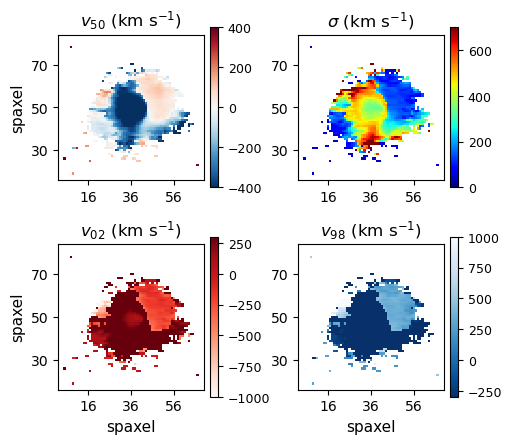

In [78]:
### plotting 1comp

%matplotlib inline
plot_kin_OIII(13, 14, fc_1comp, err_fc_1comp, v50_1comp, vsig_1comp, v02_1comp, v98_1comp)


<IPython.core.display.Javascript object>


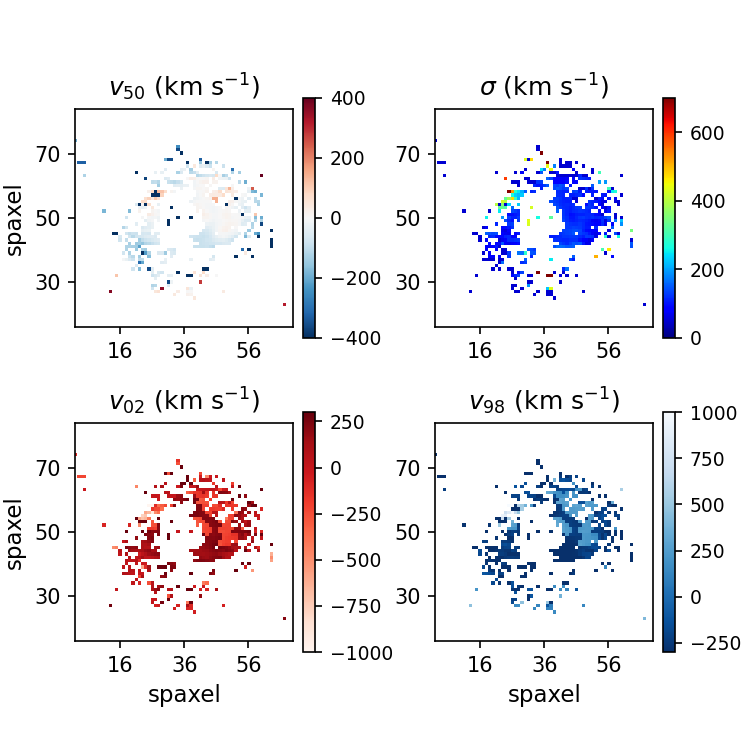

In [81]:
### plotting c1

%matplotlib notebook
plot_kin_OIII(13, 14, fc1, err_fc1, v50_c1, vsig_c1, v02_c1, v98_c1)
#  err_thresh = 0.0035

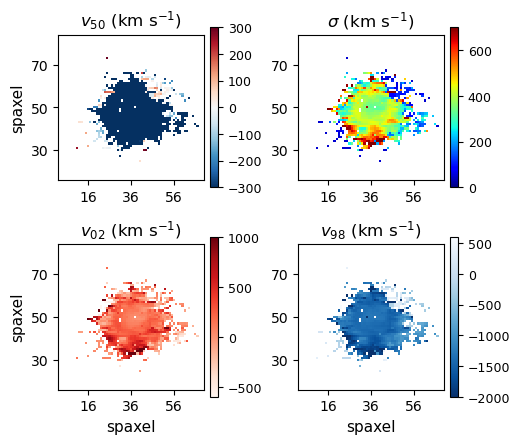

In [80]:
### plotting c2

%matplotlib inline
plot_kin_c2_OIII(13, 14, fc2, err_fc2, v50_c2, vsig_c2, v02_c2, v98_c2)


<IPython.core.display.Javascript object>


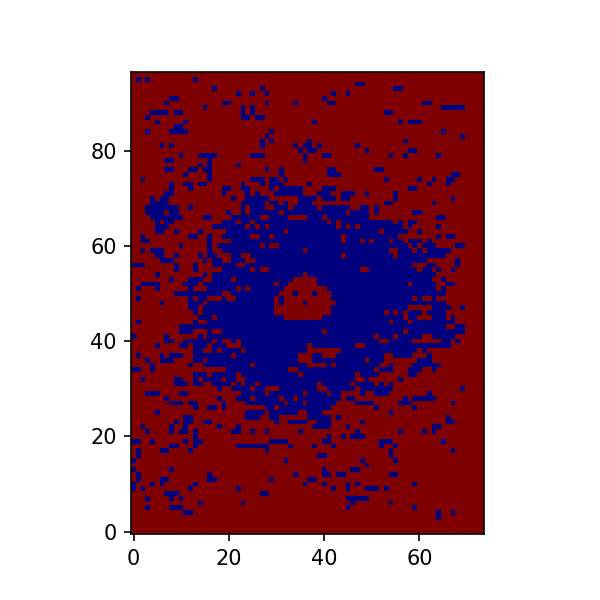

In [40]:
%matplotlib notebook

figure(figsize=(4,4))
ax = subplot(111)
im = ax.imshow(vsig_c1[13][1], origin='lower', cmap='jet')